### Ultimate Notebook for Brain Lateralization Paper

Here is the collection of all the analyses performed for the paper on brain lateralization. The analyses are organized in the following way:

1. TVB part
    - Raw Signal examples
    - Apply signal processing to Local Field Potentials (LFPs) on Left and Right pCNG:
        - counting spike frequency in gamma band (30-100 Hz) and theta band (4-8 Hz) after applying a bandpass filter
        - calculate amplitude envelope of the signal
        - include burst analyses (from David's blog: [link](https://spikesandbursts.wordpress.com/2023/08/24/patch-clamp-data-analysis-in-python-bursts/))
        - calculate the coherence between the two LFPs
        - calculate the phase distribution of two signals
    - Structural Connectivity
        - Distribution of left and right tract strengths
        - Distribution of Homotopic and heterotopic connections
        - Weighted Degree Centrality of pCNG
    - Meta Connectivity
        (to be continued)

In [6]:
import sys
sys.path.append('/Users/yilewang/workspaces/')

In [7]:
import numpy as np
import pandas as pd
 
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
 
import matplotlib.pyplot as plt
from os.path import join as pjoin
from tvbtools.tools.burst_detection import BurstDetection
import seaborn as sns

In [8]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
# # read k21.txt save as variable k21
# K21 = np.loadtxt(f'/Users/yilewang/workspaces/tvbdemos/clinical_conversion/local_inhibition_lfp/K21.txt', dtype=float)


basedir = "/Volumes/lab4data/local_inhibition_only_gc/"
# only_go = pjoin(basedir, "local_inhibition_only_go")
# only_gc = pjoin(basedir, "local_inhibition_only_gc")
# go_gc_K21 = pjoin(basedir, "local_inhibition_lfp_K21")

In [9]:
# create a pd dataframe to save the results
col_names = ['group','caseid', 'gc', "Number_bursts",	"Spikes_Bursts",	"Spikes_Bursts_ratio",	"Mean_Burst_Duration", 
             'mean_isi','median_isi','kurtosis'	,'skewness','cma_threshold'	,'cma_valley_time',	'cma_peak_time', 
             "avg_spike_amp", "avg_inst_freq", "avg_spike_peak"]
bursts_results_left = pd.DataFrame(columns=col_names)
bursts_results_right = pd.DataFrame(columns=col_names)
for case, gr, gc in zip(mega_data.caseid, mega_data.group, mega_data.Gc):
    # read the data
    filename = pjoin(basedir, gr, f"{case}_{gc}.npy")
    lfp = np.load(filename)
    pCNG_l = lfp[8192:,0, 4, 0]
    pCNG_r = lfp[8192:,0, 5, 0]

    # for the right
    burst_right = BurstDetection(data = pCNG_r, fs = 81920)
    spikes_table_right = burst_right.generate_spikes_analyses()
    bursts_table_right = burst_right.bursts_detection(spikes_table_right, 'spike_time', 
                         'spike_amplitude',
                         'spike_peak',
                         n_spikes = 2,  
                         max_isi = 0.1,
                         # min_duration = 0.5,  # Optional
                         min_ibi = 0.2)
    bursts_stats_right = burst_right.generate_bursts_stats(caseid=case, bursts_table=bursts_table_right, spikes_table=spikes_table_right)
    isi_right = burst_right.generate_ISI_analyses(spikes_table_right)
    
    # average spike amplitude
    if len(spikes_table_right)==0:
        avg_spike_amp_right = 0
    else:
        avg_spike_amp_right = np.mean(spikes_table_right.spike_amplitude)
    # average instant frequency
    if len(spikes_table_right)==0:
        avg_inst_freq_right = 0
    else:
        avg_inst_freq_right = np.mean(spikes_table_right.inst_freq[1:])
    # average spike peak
    if len(spikes_table_right)==0:
        avg_spike_peak_right = 0
    else:
        avg_spike_peak_right = np.mean(spikes_table_right.spike_peak)


    # create single pd dataframe and concat later
    _a =[ gr,case, gc]
    _b = [*bursts_stats_right.values.ravel()][1:]
    _c = [*isi_right.values.ravel()]
    _d = [avg_spike_amp_right, avg_inst_freq_right, avg_spike_peak_right]
    # concate the list _a _b _c
    _one = _a + _b + _c + _d

    _single = pd.DataFrame(_one, index=col_names)
    bursts_results_right = pd.concat([bursts_results_right, _single.T], axis=0)


    # for the left
    burst_left = BurstDetection(data = pCNG_l, fs = 81920)
    spikes_table_left = burst_left.generate_spikes_analyses()
    bursts_table_left = burst_left.bursts_detection(spikes_table_left, 'spike_time', 
                         'spike_amplitude',
                         'spike_peak',
                         n_spikes = 2,  
                         max_isi = 0.1,
                         # min_duration = 0.5,  # Optional
                         min_ibi = 0.2)
    bursts_stats_left = burst_left.generate_bursts_stats(caseid=case, bursts_table=bursts_table_left, spikes_table=spikes_table_left)
    isi_left = burst_left.generate_ISI_analyses(spikes_table_left)

    # average spike amplitude
    if len(spikes_table_left)==0:
        avg_spike_amp_left = 0
    else:
        avg_spike_amp_left = np.mean(spikes_table_left.spike_amplitude)
    # average instant frequency
    if len(spikes_table_left)==0:
        avg_inst_freq_left = 0
    else:
        avg_inst_freq_left = np.mean(spikes_table_left.inst_freq[1:])
    # average spike peak
    if len(spikes_table_left)==0:
        avg_spike_peak_left = 0
    else:
        avg_spike_peak_left = np.mean(spikes_table_left.spike_peak)


    # create single pd dataframe and concat later
    _a =[ gr,case, gc]
    _b = [*bursts_stats_left.values.ravel()][1:]
    _c = [*isi_left.values.ravel()]
    _d = [avg_spike_amp_left, avg_inst_freq_left, avg_spike_peak_left]
    # concate the list _a _b _c
    _one = _a + _b + _c + _d
    _single = pd.DataFrame(_one, index=col_names)
    bursts_results_left = pd.concat([bursts_results_left, _single.T], axis=0)


bursts_results_left.to_csv(pjoin(basedir, "bursts_results_left.csv"), index=False)
bursts_results_right.to_csv(pjoin(basedir, "bursts_results_right.csv"), index=False)

No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected


In [10]:
bursts_results_left = pd.read_csv(pjoin(basedir, "bursts_results_left.csv"))
bursts_results_right = pd.read_csv(pjoin(basedir, "bursts_results_right.csv"))
ta = bursts_results_right
col = ta.columns[3:]

# for var in col:
#     figure = plt.figure(figsize=(10, 5))
#     sns.violinplot(x="group", y=var, data=ta, cut=0, inner = None)
#     sns.stripplot(x="group", y=var, data=ta, dodge=True, jitter=True, color='black')
#     sns.pointplot(x="group", y=var, data=ta, color='r', errorbar=None)


In [11]:
import statannot

In [12]:

def before_after_graph(befores, afters, ax, ylim=[-0.5, 35]):
    # plotting the points
    ax.scatter(np.zeros(len(befores)), befores, s=1, color='k')
    ax.scatter(np.ones(len(afters)), afters, s=1, color='k')
    # plotting the lines
    for i in range(len(befores)):
        ax.plot( [0,1], [befores[i], afters[i]], alpha=0.2, color='k')
    # hide the frame
    sns.despine(top=True, right=True, left=True)
    # ax.set_xticks([0.25, 0.75], ['gc', 'gc_K21'])
    ax.set_xticks([])
    # find max of befores and afters
    ax.set_ylim(ylim)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SNC_l v.s. SNC_r: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.032e-03 U_stat=1.450e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NC_l v.s. NC_r: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.177e-04 U_stat=2.950e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCI_l v.s. MCI_r: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.473e-07 U_stat=1.745e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

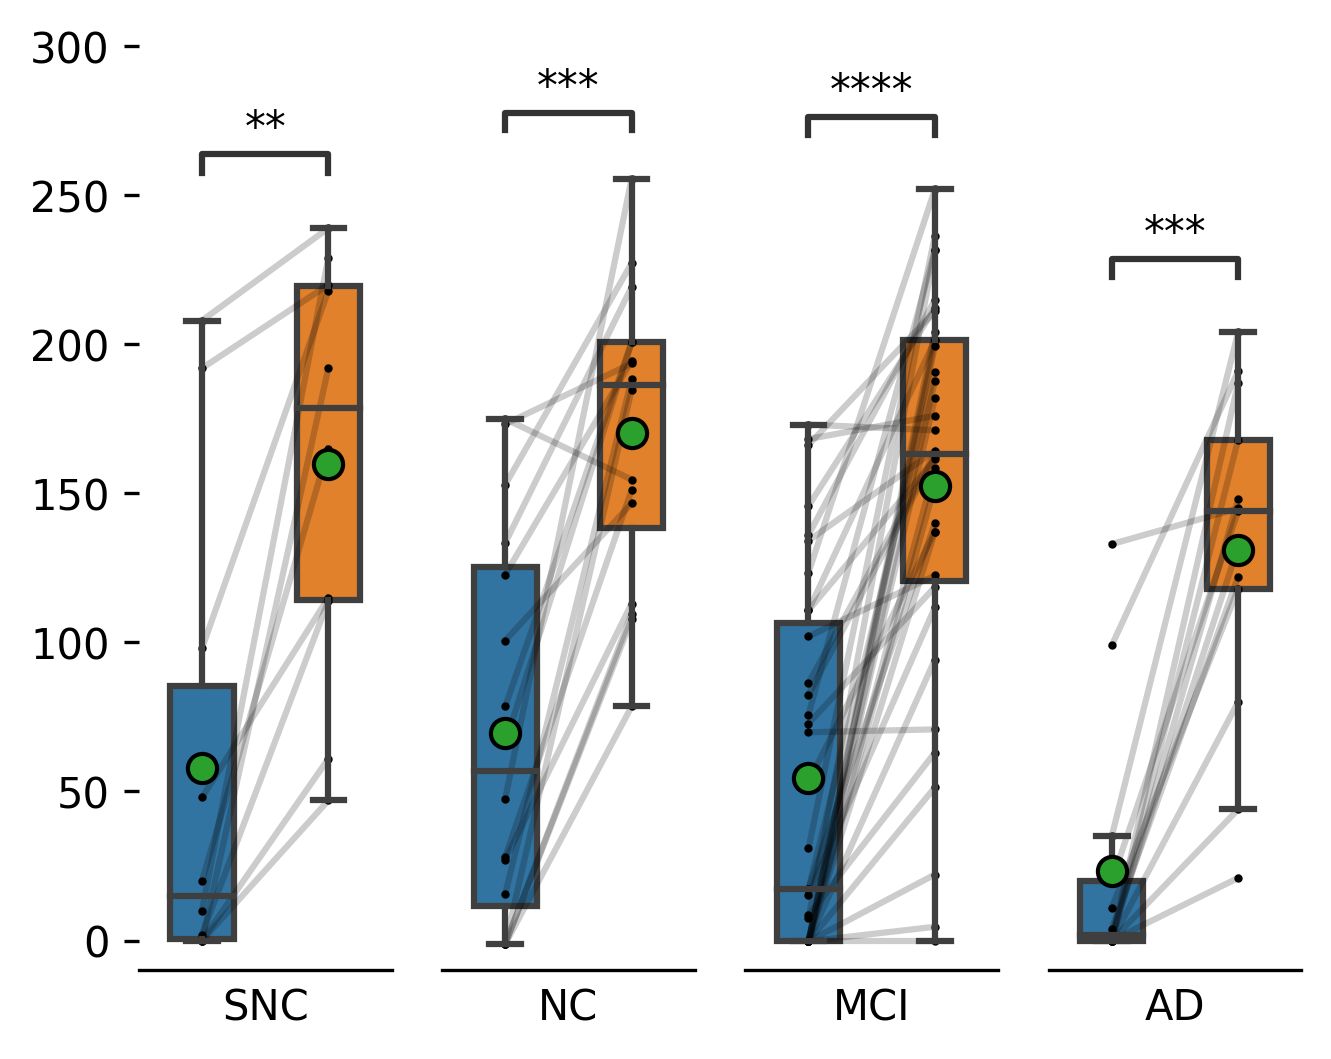

In [13]:
groups = ["SNC", "NC", "MCI", "AD"]
figure = plt.figure(figsize=(5, 4), dpi=300)
ax1 = figure.add_subplot(1, 4, 1)
ax2 = figure.add_subplot(1, 4, 2)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax3 = figure.add_subplot(1, 4, 3)
ax3.set_yticklabels([])
ax3.set_yticks([])
ax4 = figure.add_subplot(1, 4, 4)
ax4.set_yticklabels([])
ax4.set_yticks([])
axs = [ax1, ax2, ax3, ax4]




for gg, ax in zip(groups, axs):
    group_data_before = np.array(bursts_results_left[bursts_results_left.group == gg][bursts_results_left.columns[4]])
    group_data_after = np.array(bursts_results_right[bursts_results_right.group == gg][bursts_results_right.columns[4]])
    before_after_graph(group_data_before, group_data_after, ax=ax, ylim=[-10, 300])
    lr = pd.concat([bursts_results_left.iloc[:,4][bursts_results_left.group == gg], bursts_results_right.iloc[:,4][bursts_results_right.group==gg]], axis=0)
    lrgg = pd.concat([bursts_results_left.group[bursts_results_left.group == gg]+"_l", bursts_results_right.group[bursts_results_right.group==gg]+"_r"], axis=0)
    bp = sns.boxplot(x=lrgg, y=lr, ax=ax, showmeans=True, width=0.5,  showfliers=False, meanprops = {"marker":"o", "markeredgecolor":"black", "markersize":"7"})
    statannot.add_stat_annotation(
    ax=ax,
    x=lrgg,
    y=lr,
    box_pairs=[
        ((gg+"_l", gg+"_r"))],
    test='Mann-Whitney',
    text_format="star")

    ax.set_ylabel("")
    ax.set_xlabel(gg)
    ax.set_xticklabels("")
    ax.set_xticks([])

In [14]:
# concate burst_results_left.iloc[,4] and burst_results_right.iloc[,4]
bursts_results_left_right = pd.concat([bursts_results_left.iloc[:,4][bursts_results_left.group == "SNC"], bursts_results_right.iloc[:,4][bursts_results_right.group=="SNC"]], axis=0)
print(bursts_results_left_right)

0     20
1     10
2      0
3      0
4      2
5      0
6    208
7     48
8     98
9    192
0    165
1    229
2     47
3    192
4    114
5     61
6    239
7    115
8    218
9    220
Name: Spikes_Bursts, dtype: int64


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NC_Left v.s. NC_Right: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.463e-01 U_stat=9.050e+01
SNC_Left v.s. SNC_Right: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.474e-01 U_stat=2.200e+01
MCI_Left v.s. MCI_Right: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.140e-02 U_stat=3.950e+02
AD_Left v.s. AD_Right: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.601e-03 U_stat=1.800e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NC_Left v.s. NC_Right: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.707e-04 U_stat=2.950e+01
SNC_Left v.s. SNC_Right: Mann-Whitney-Wilcoxon test two-sided w

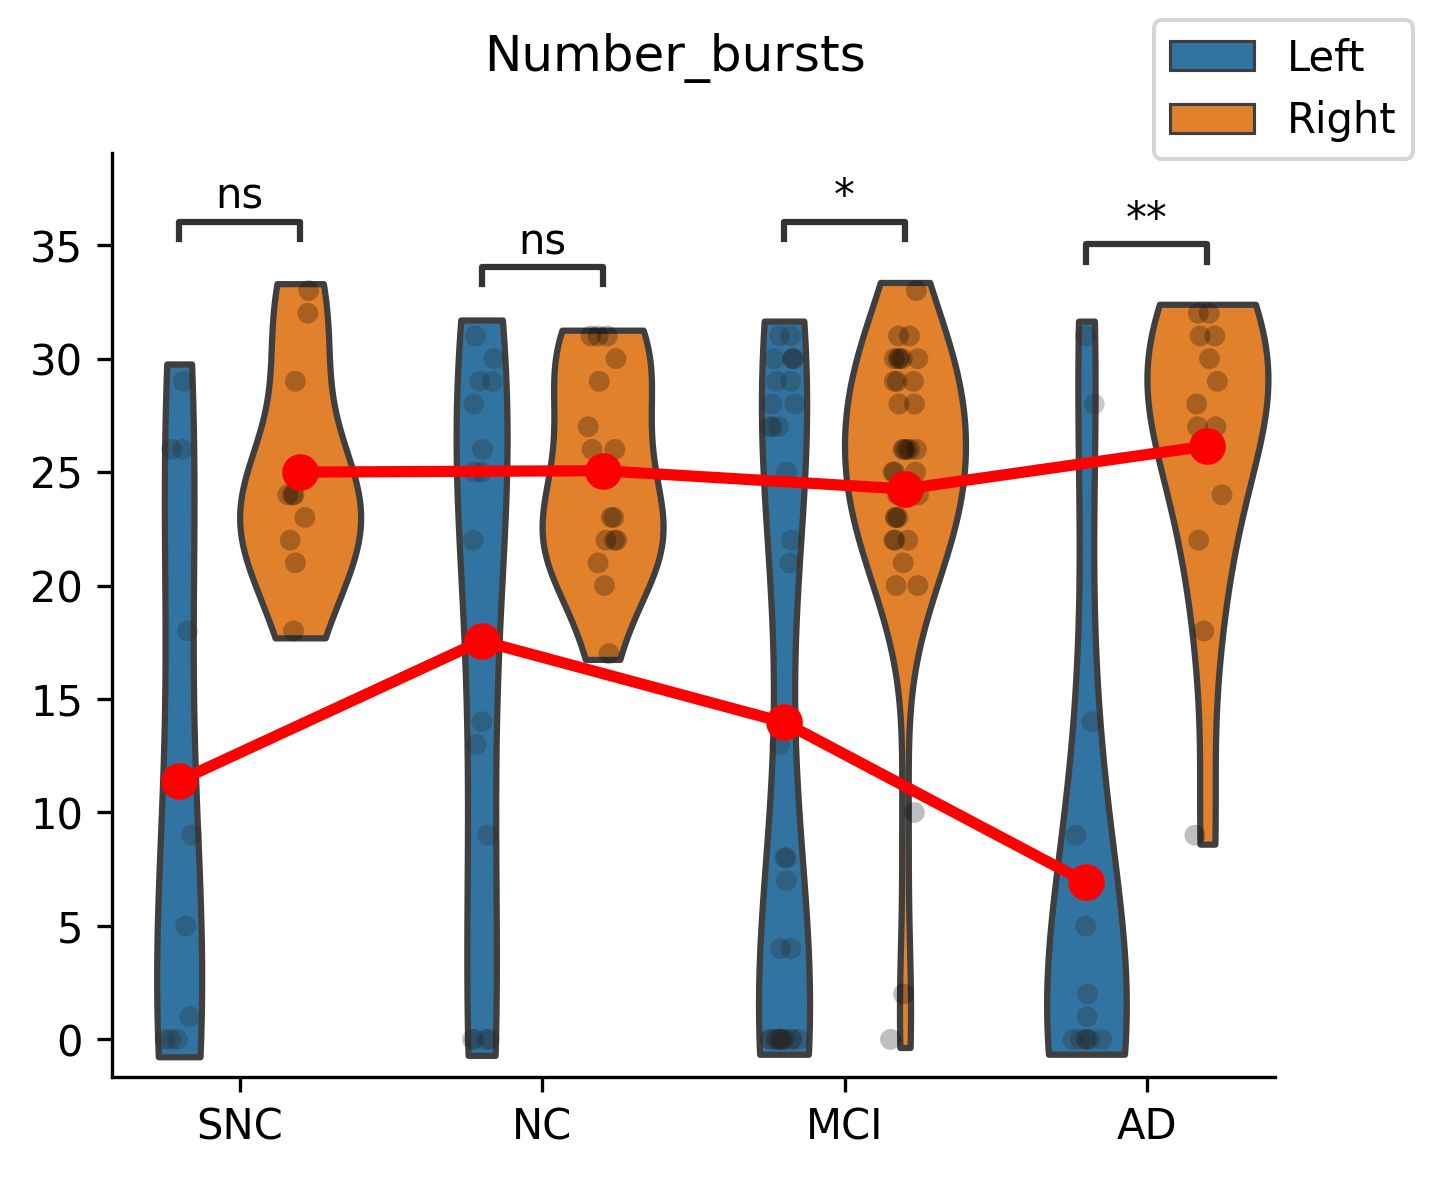

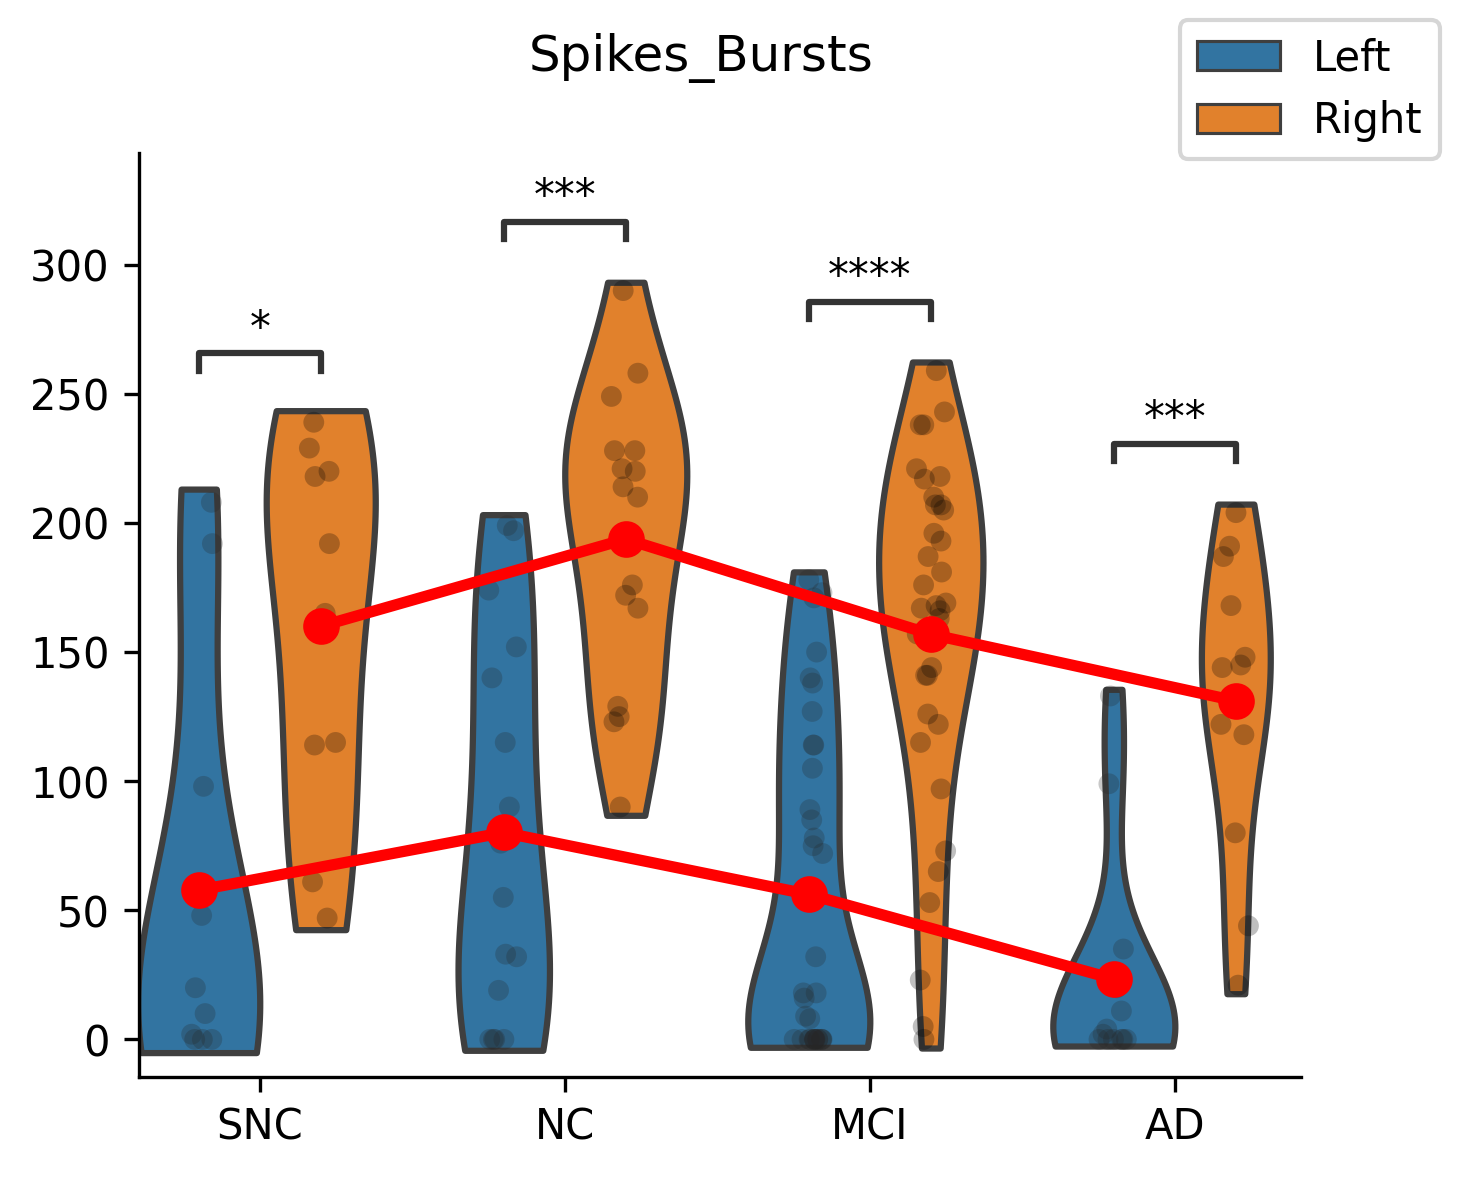

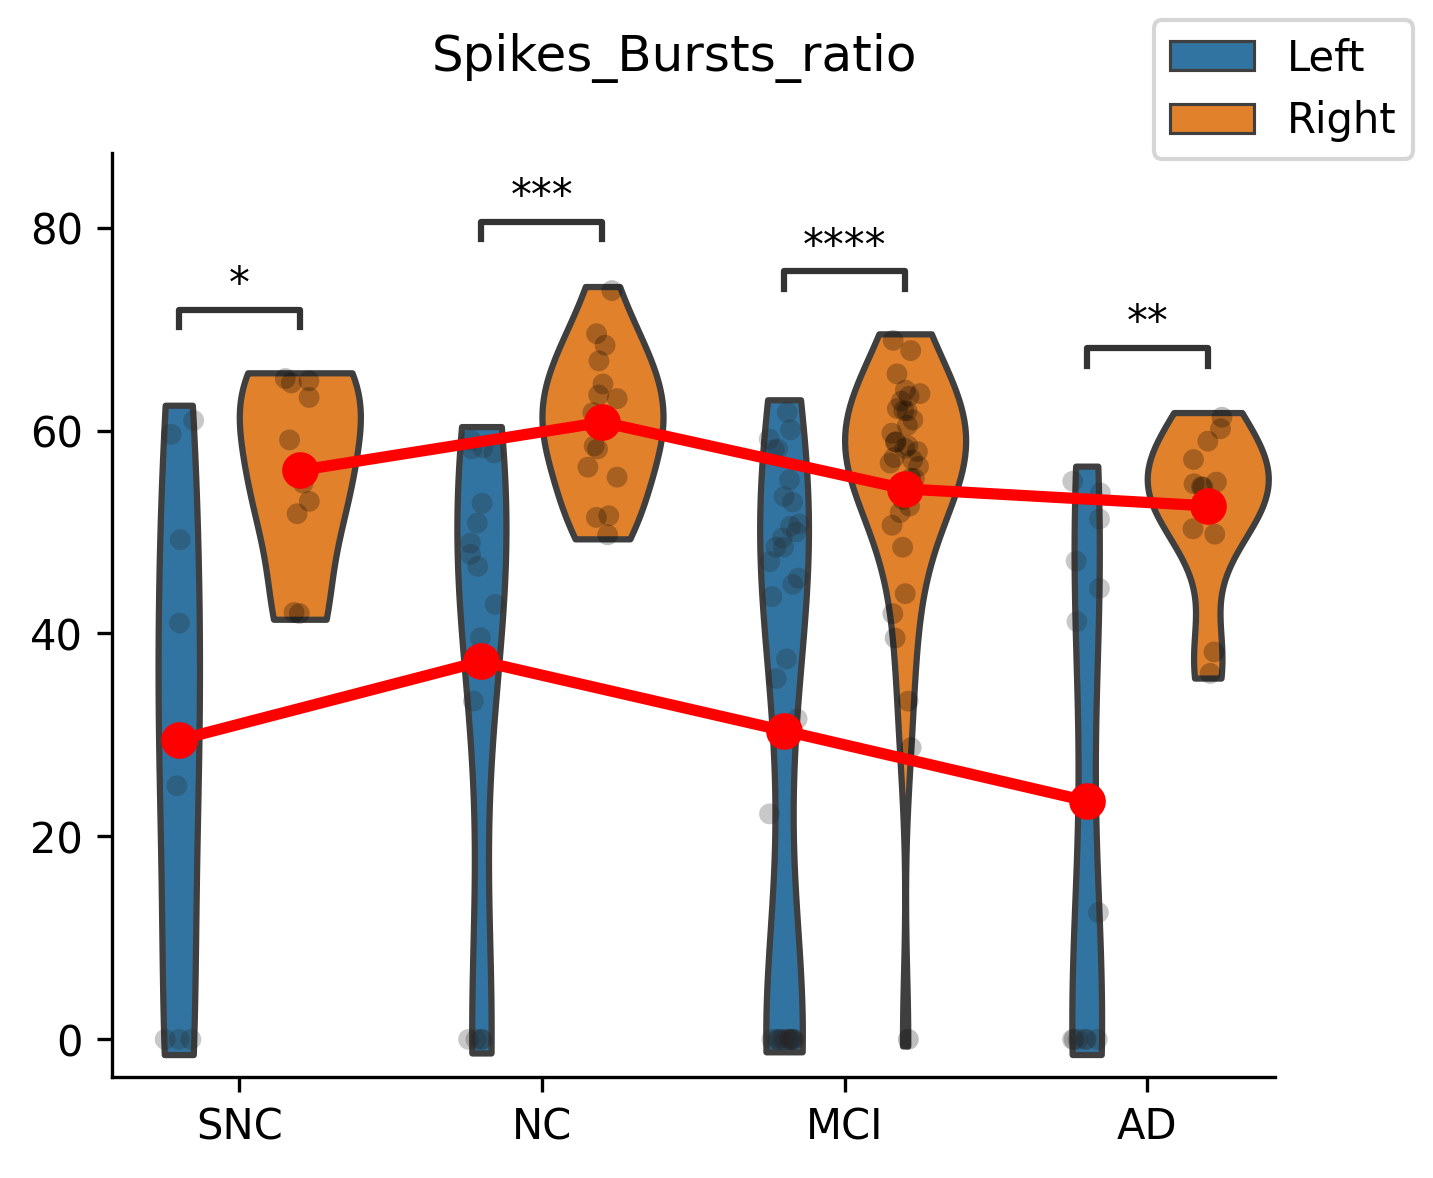

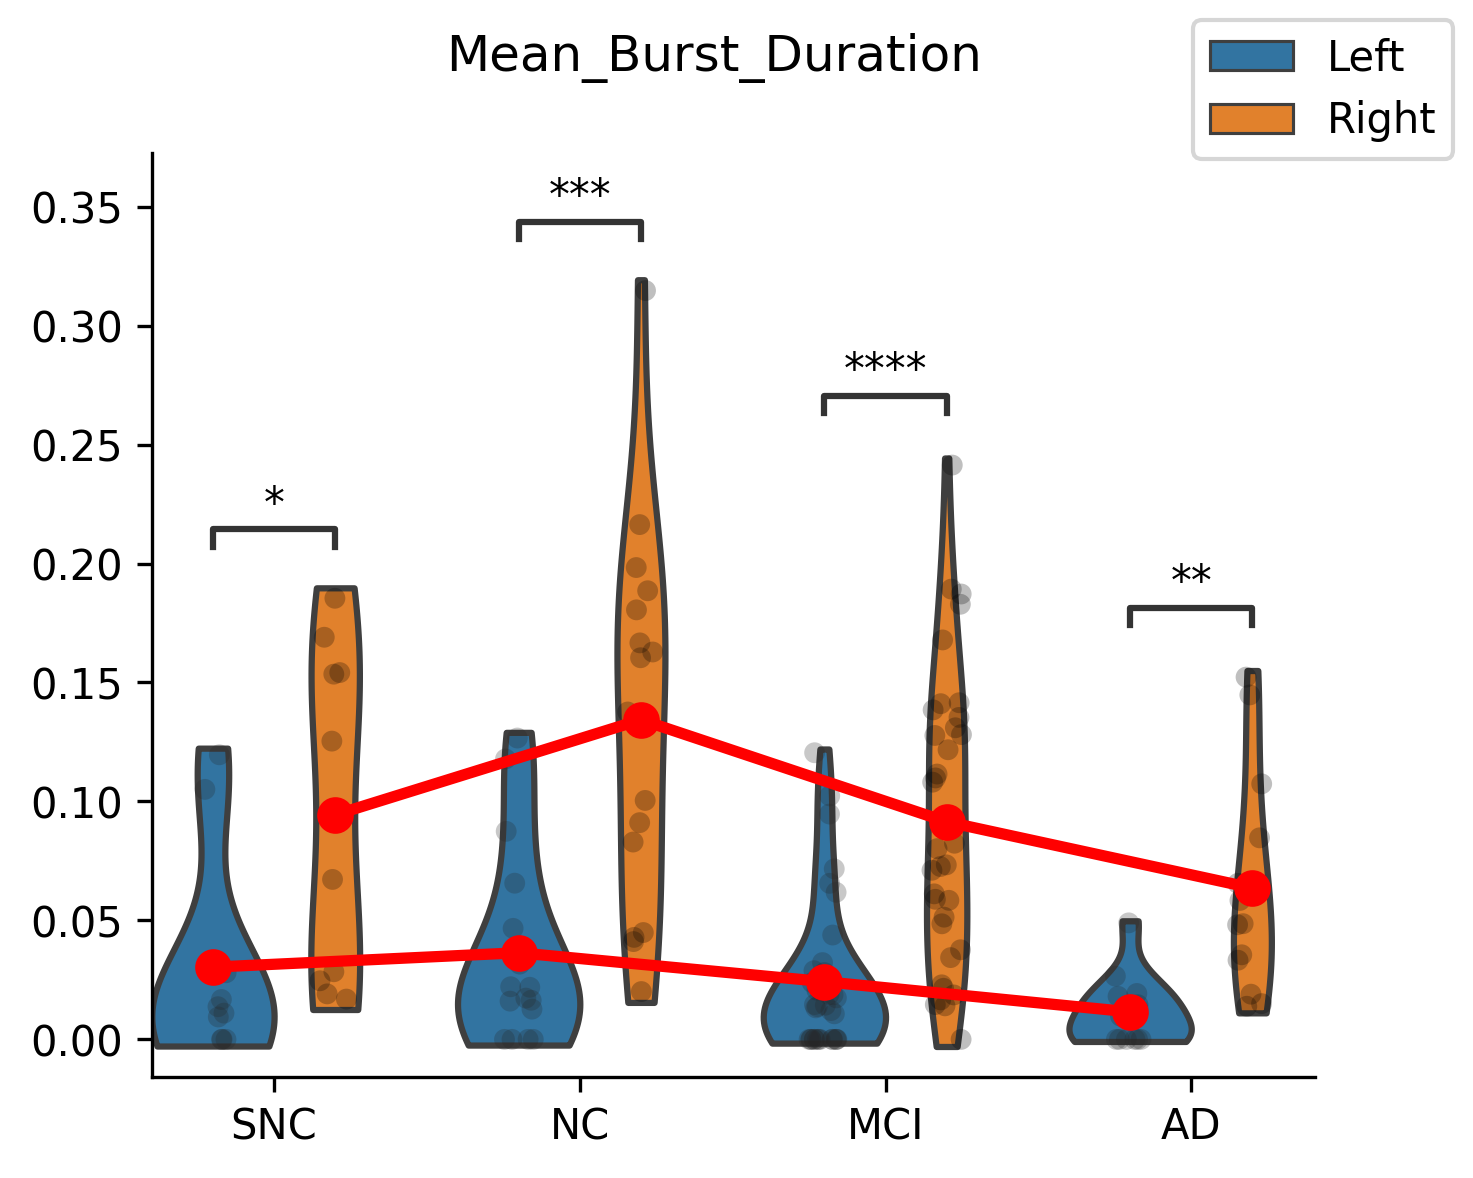

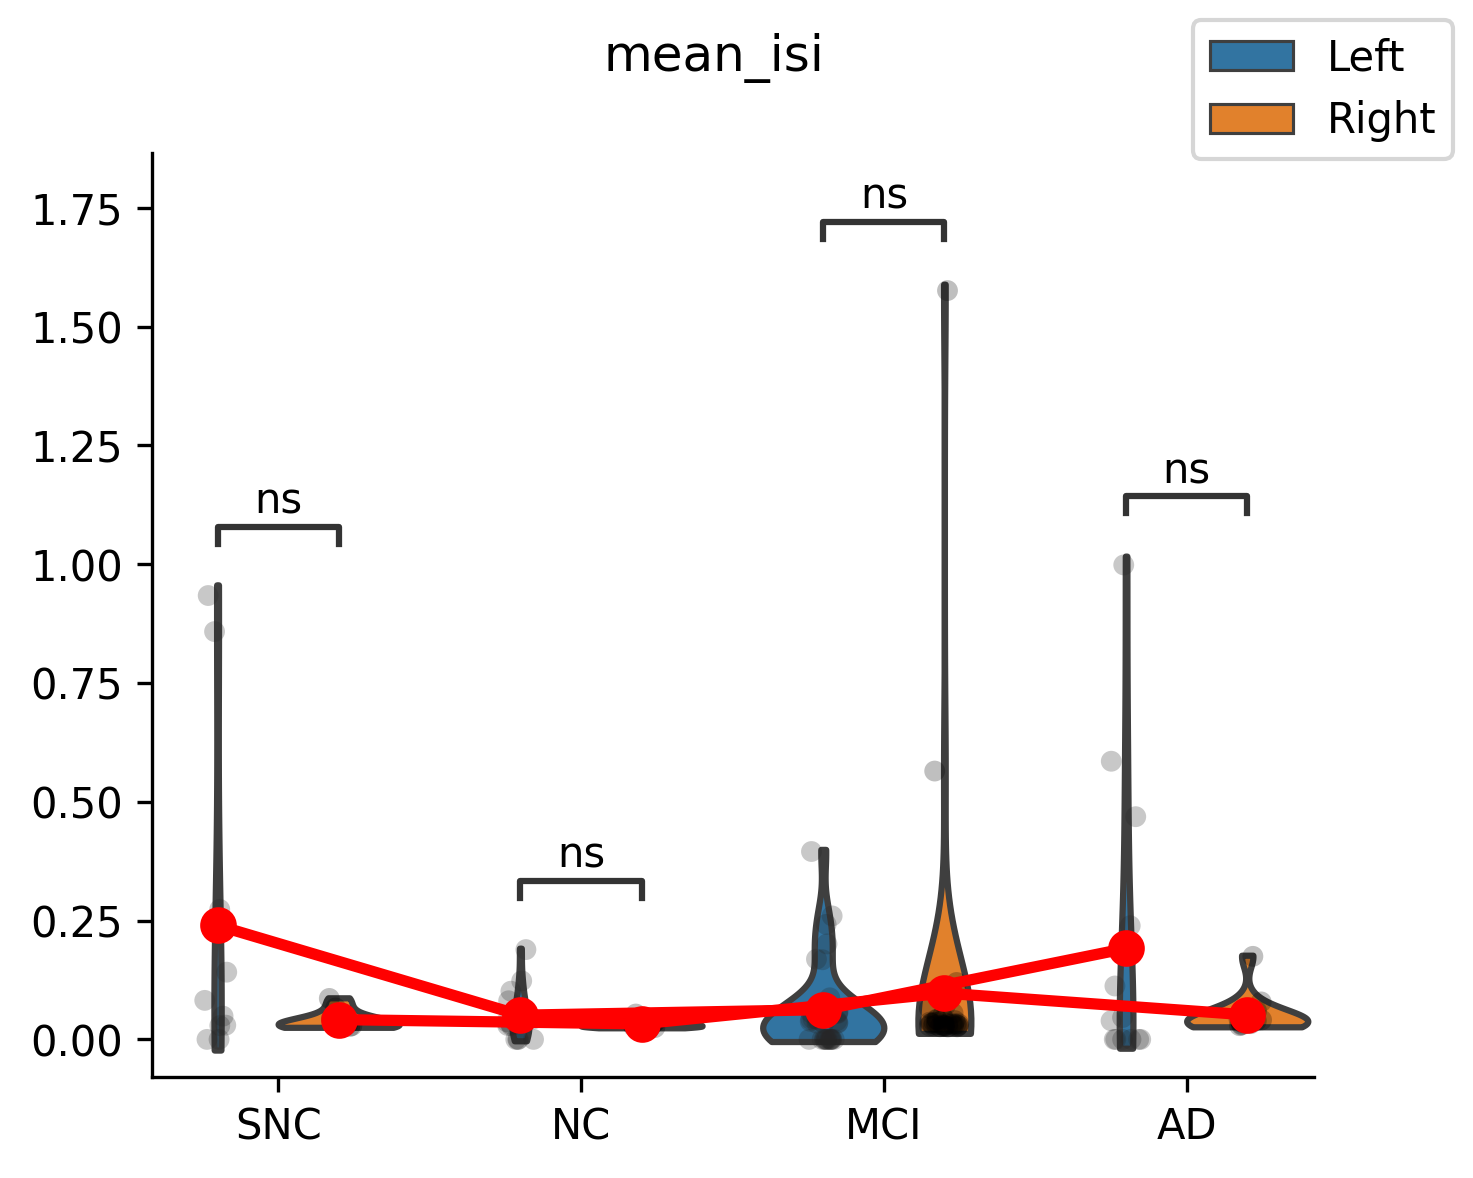

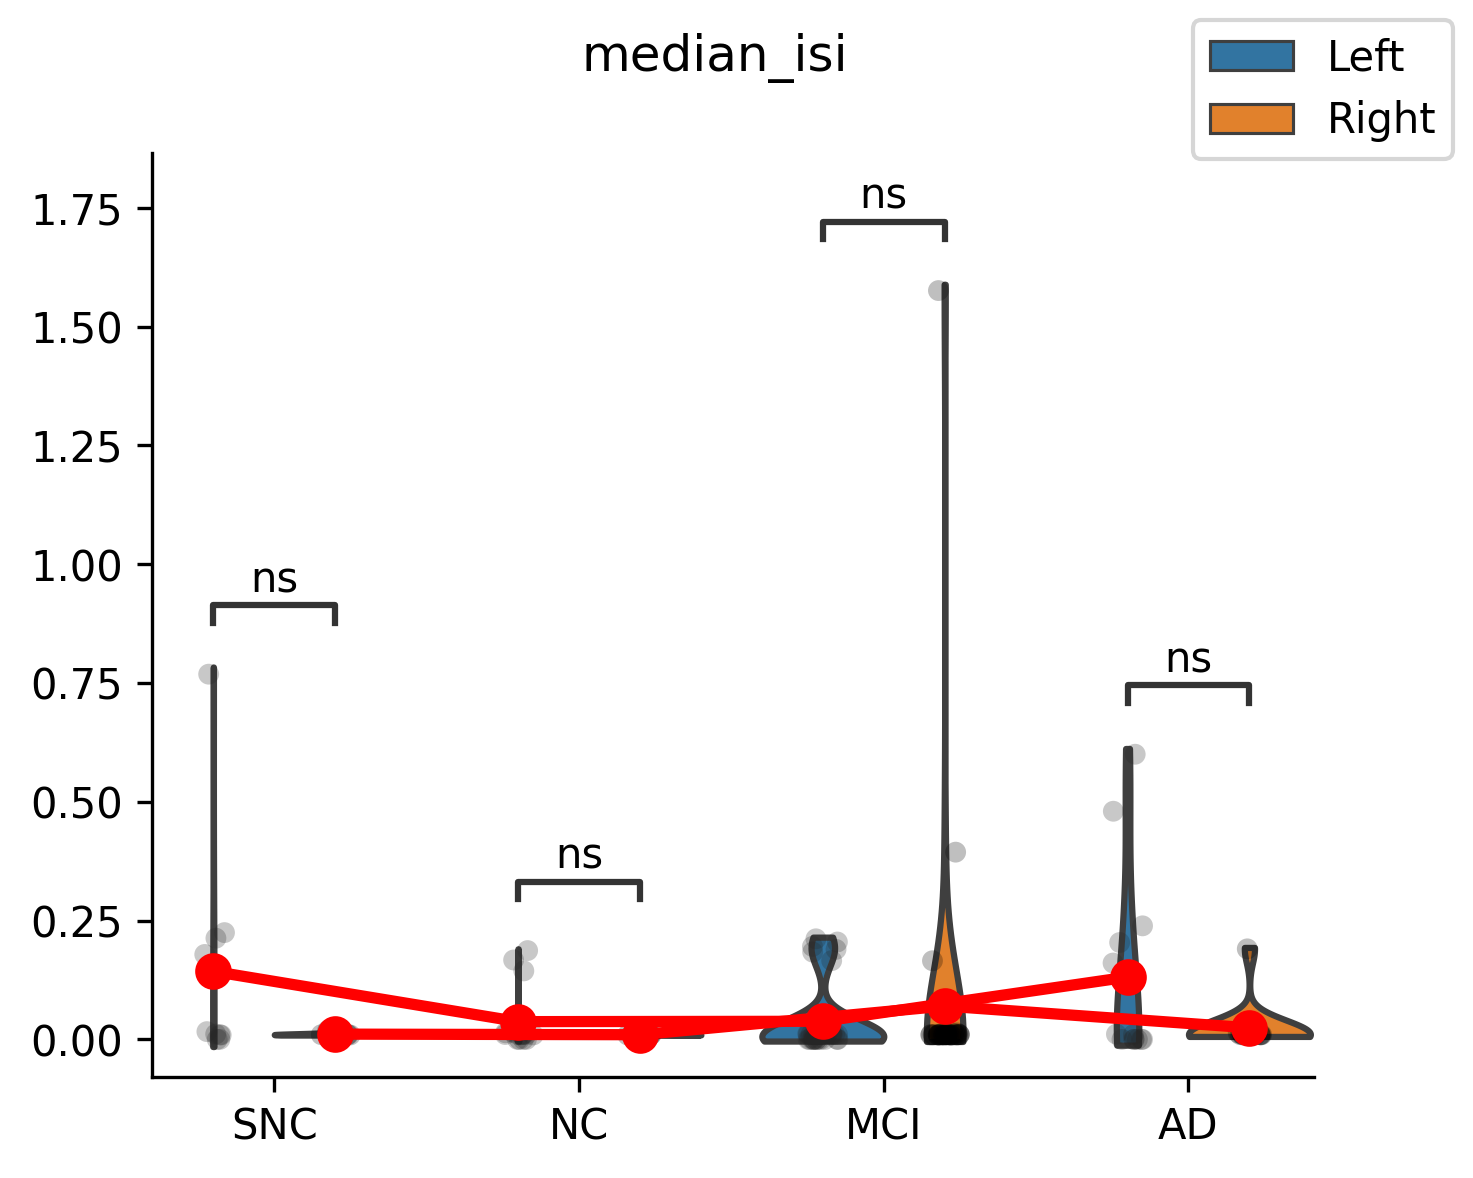

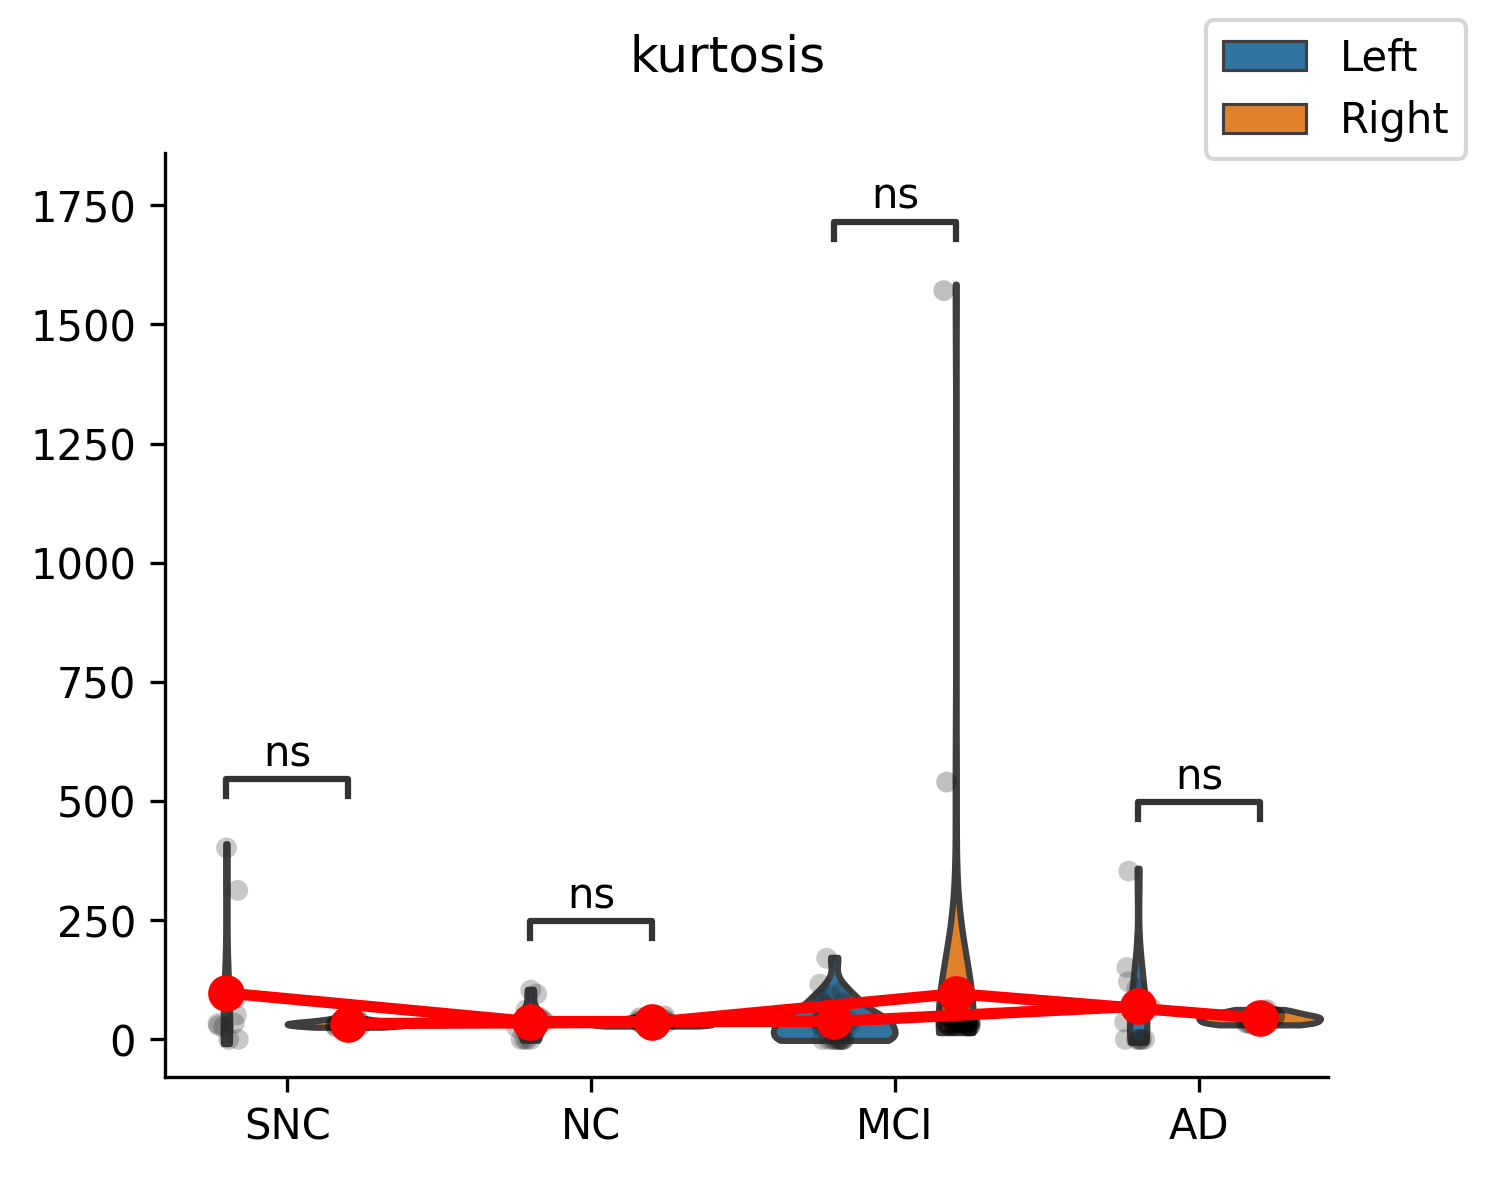

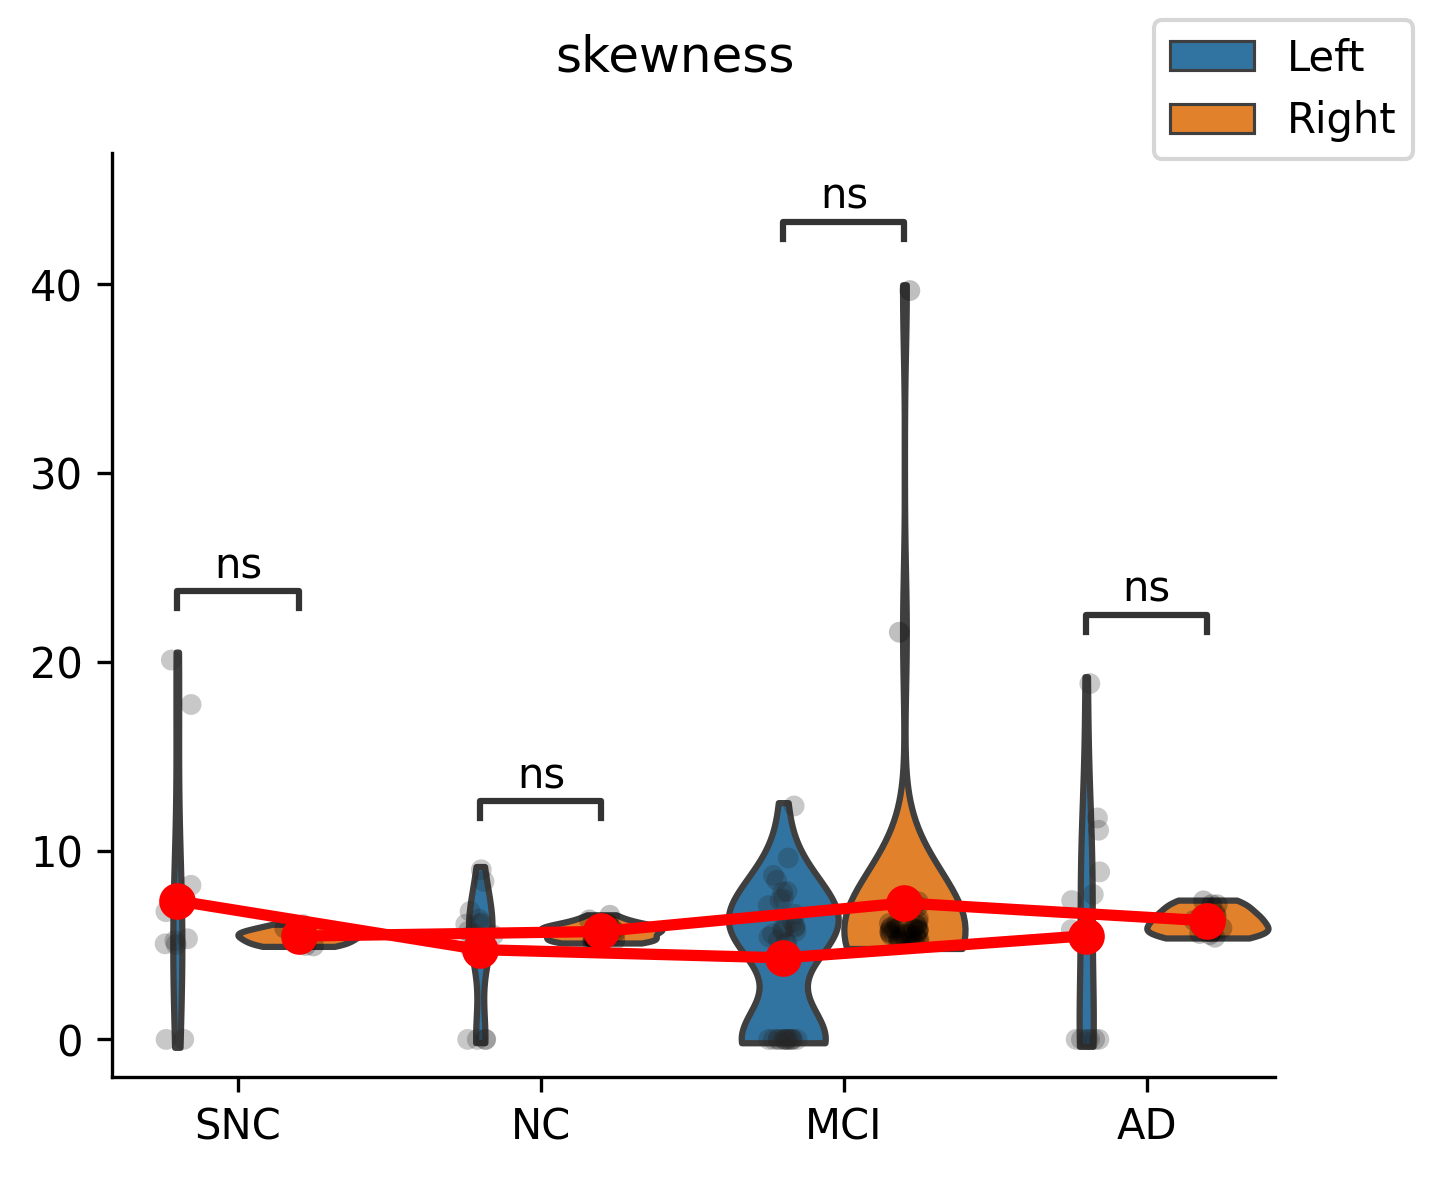

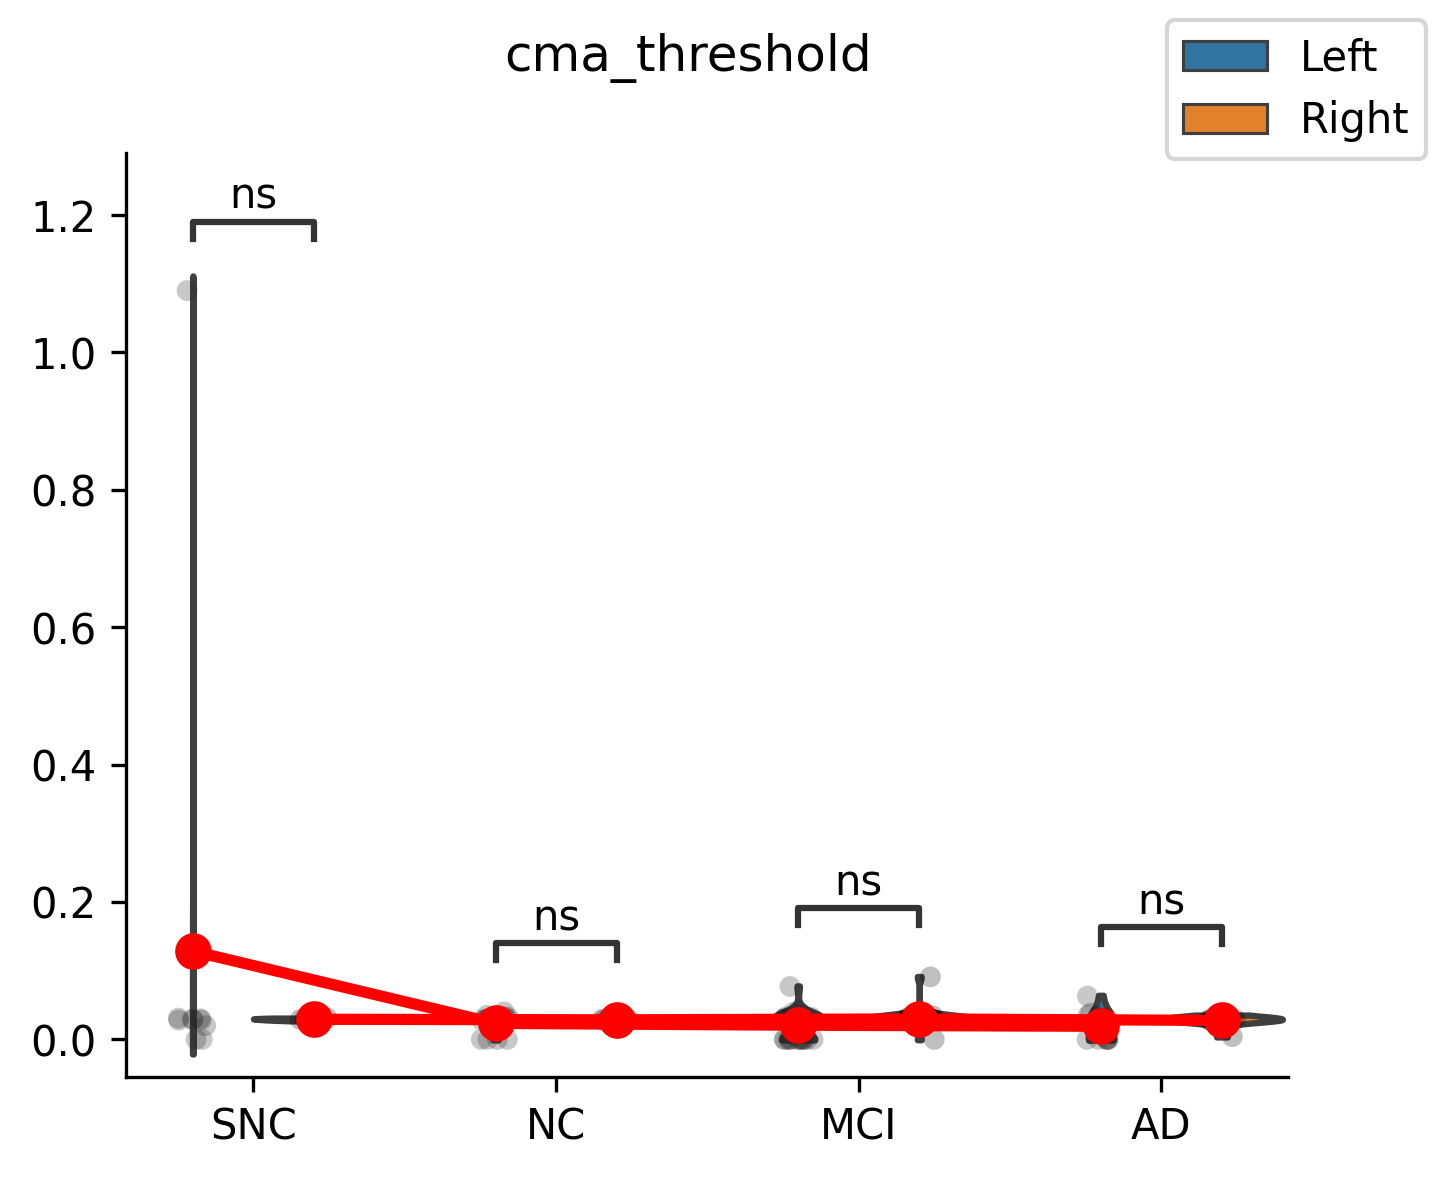

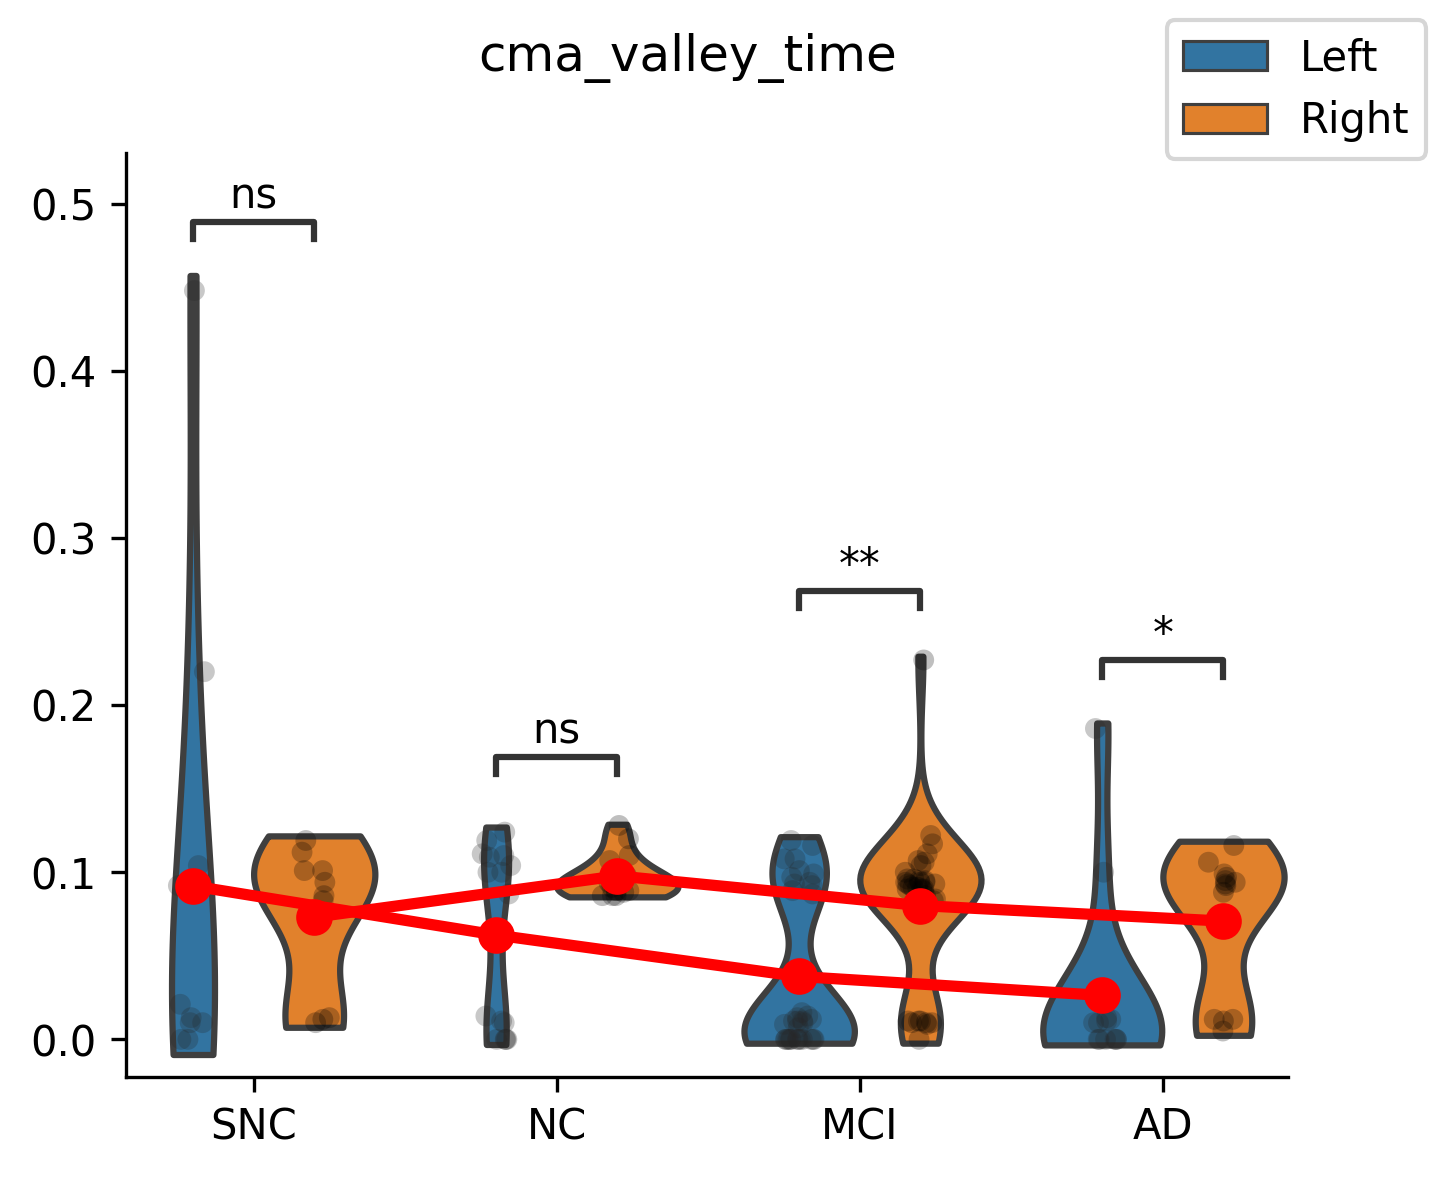

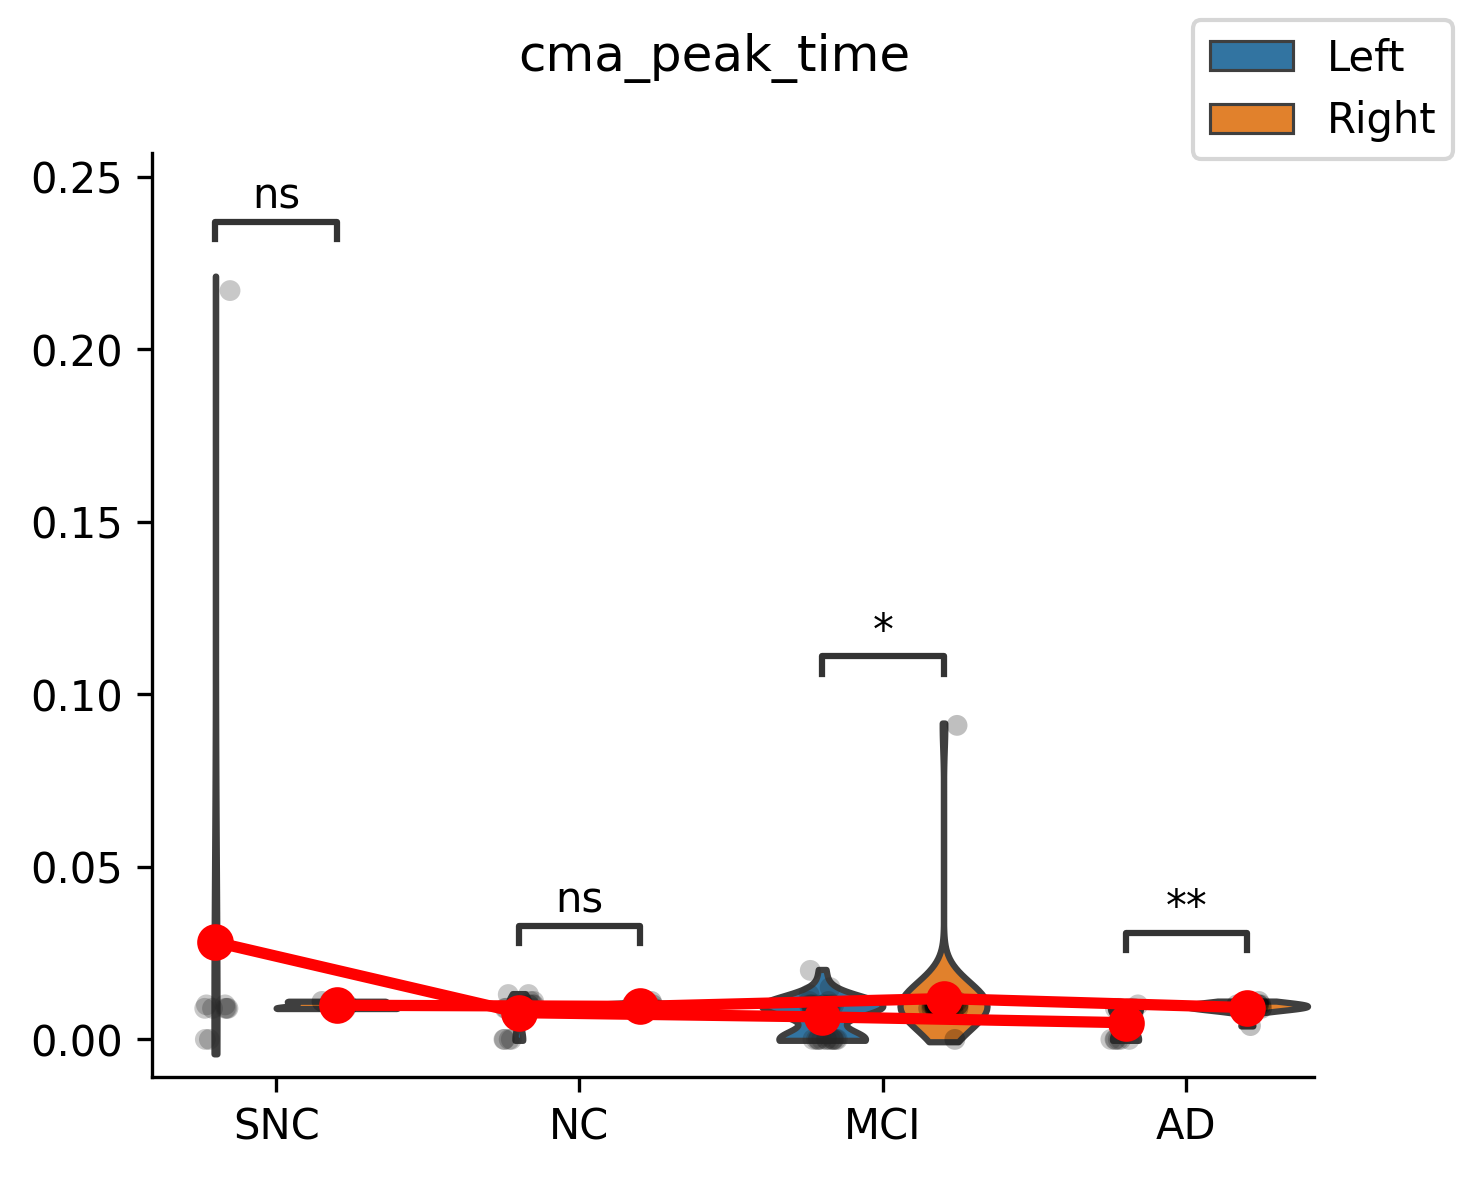

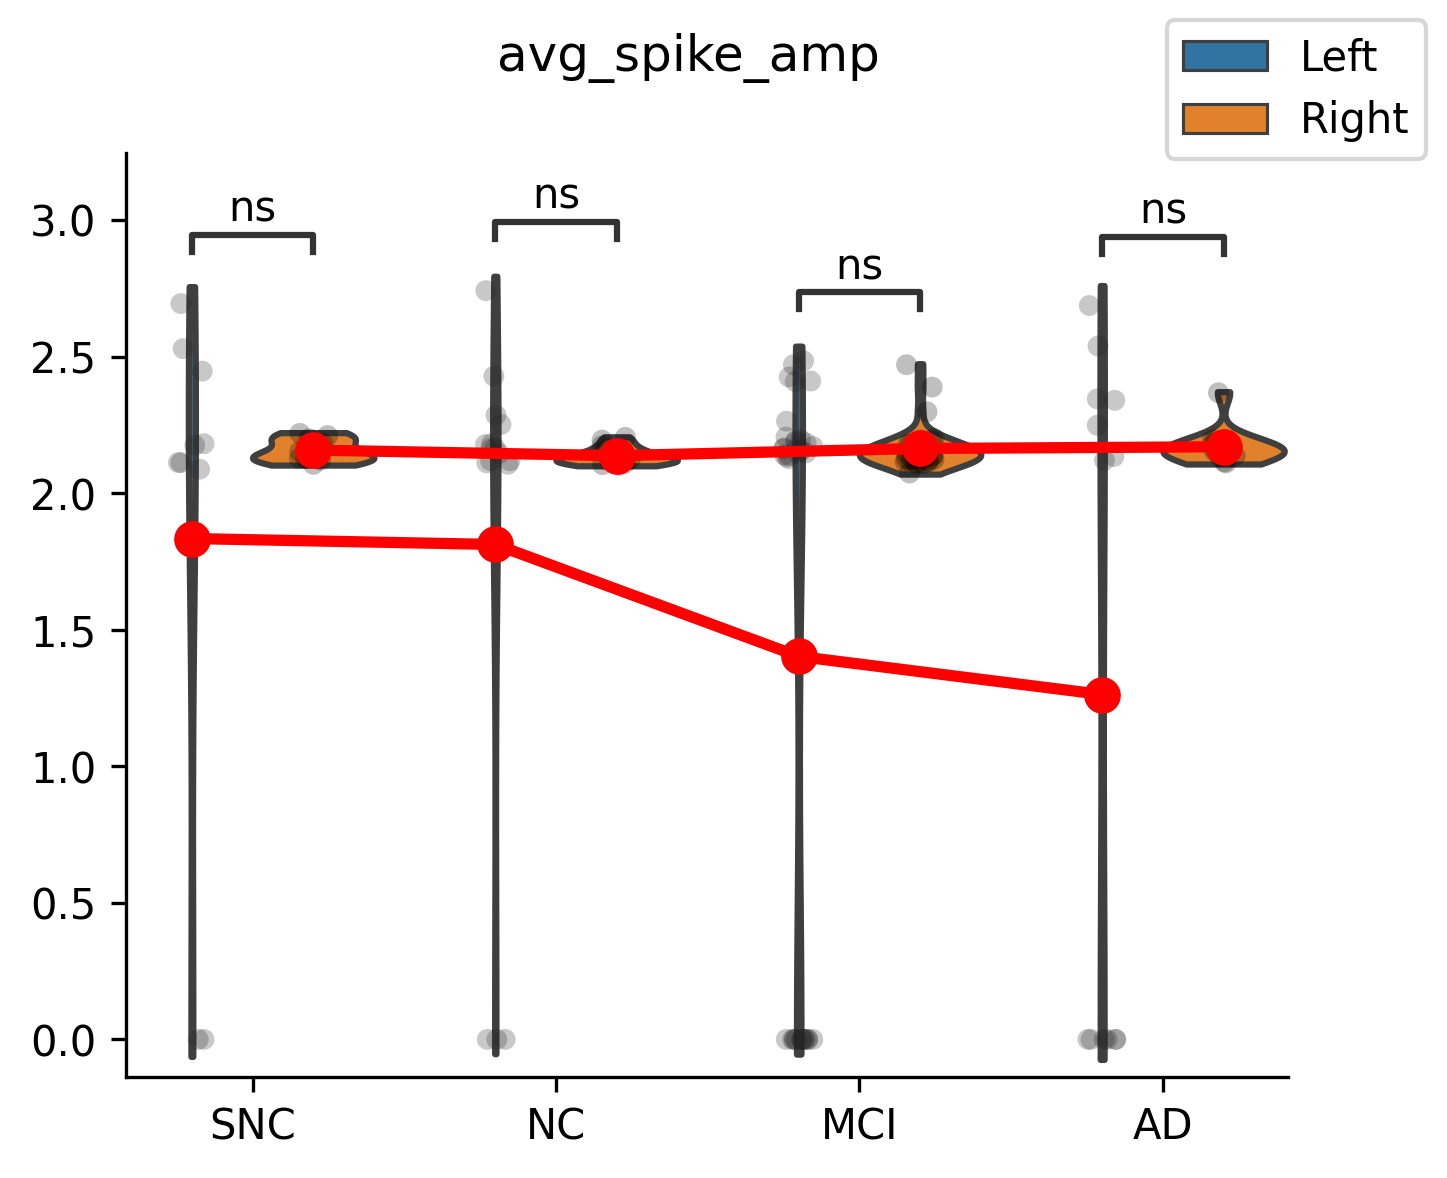

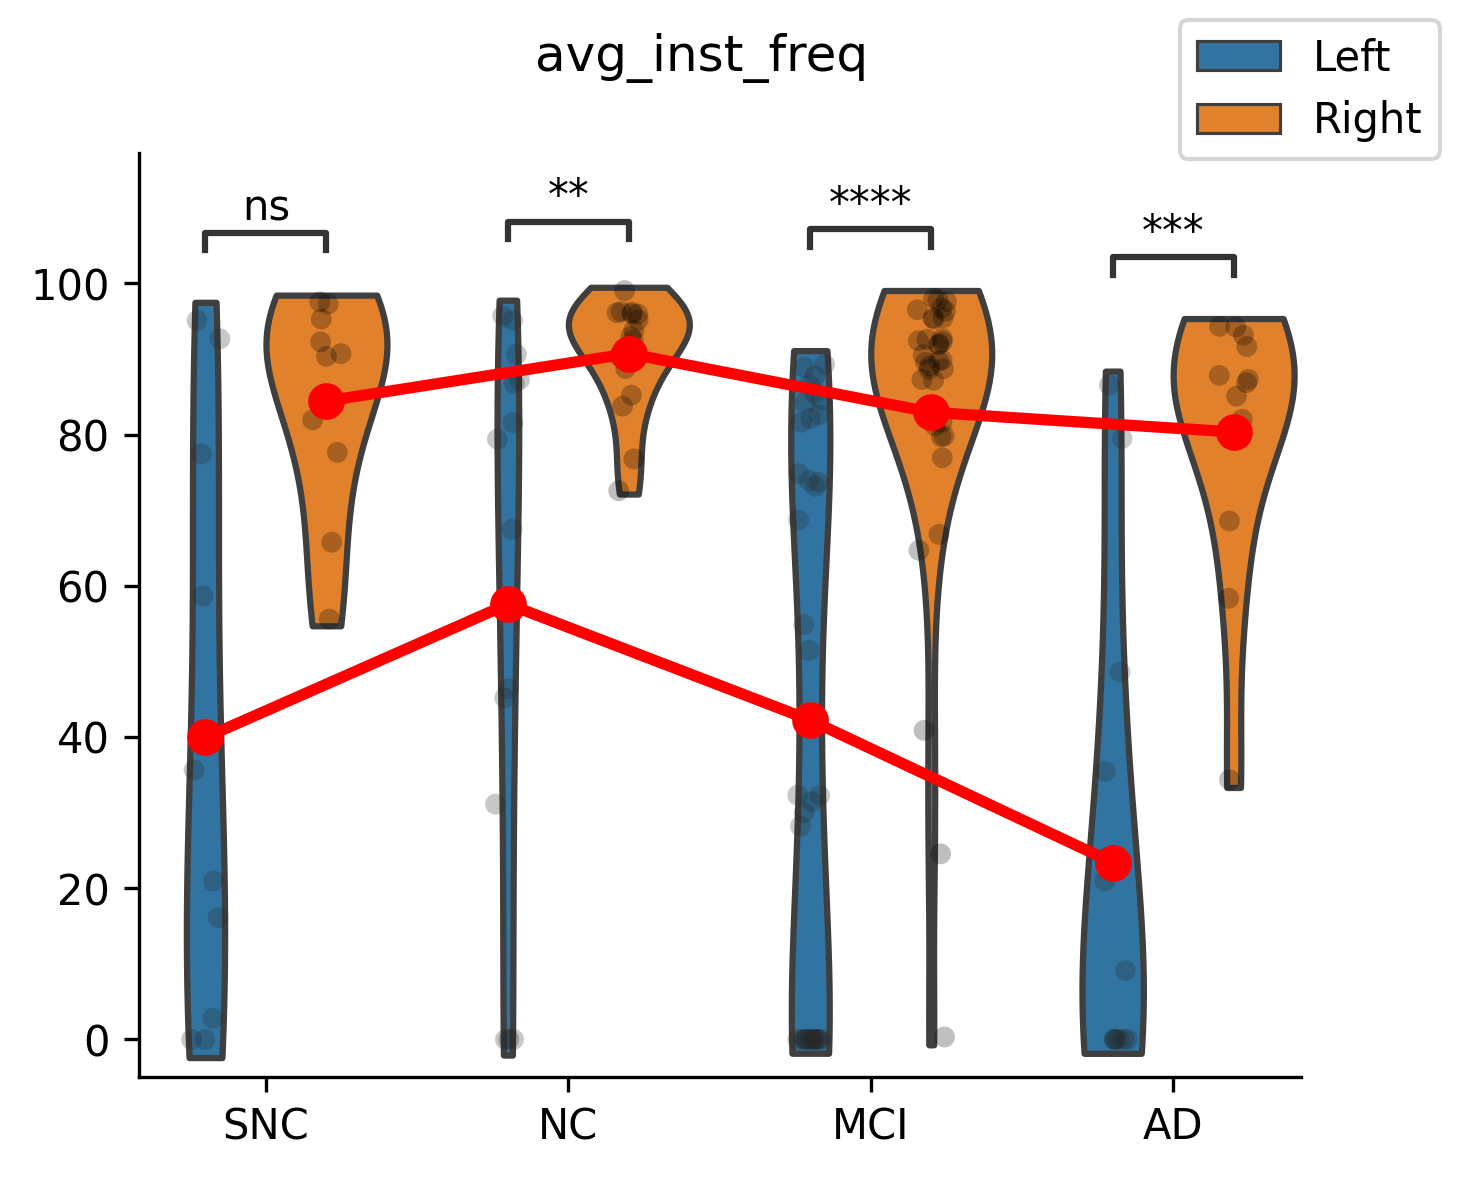

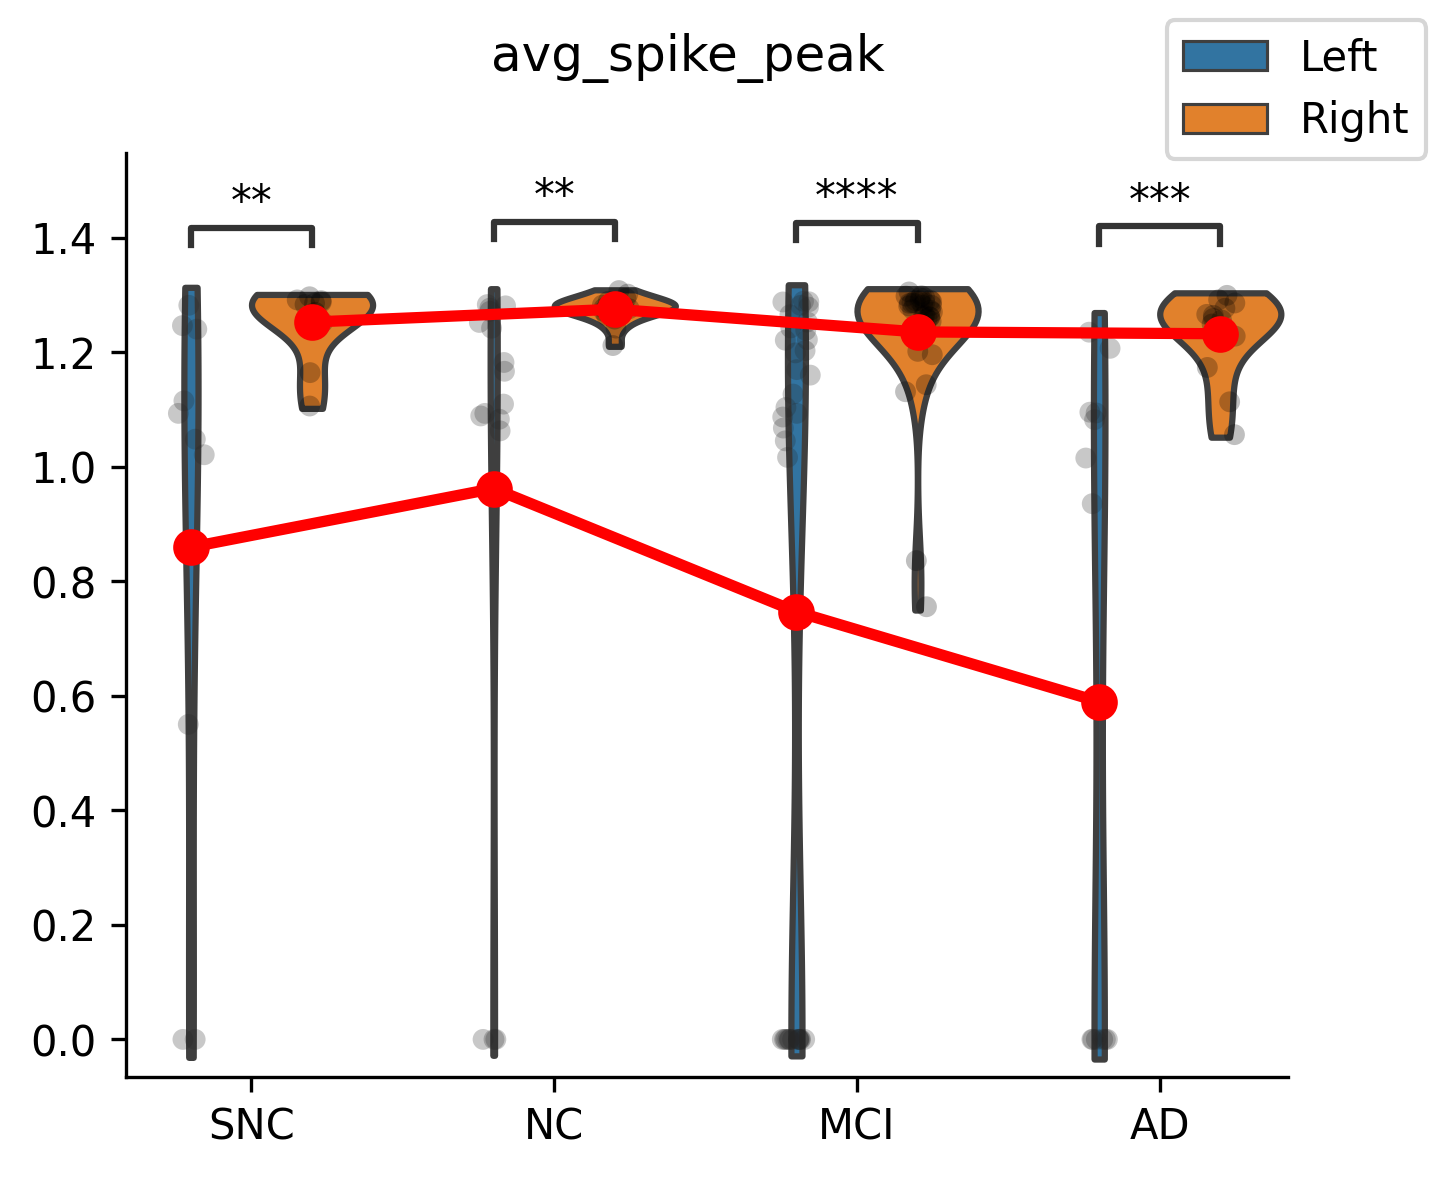

In [15]:
sides = ["Left"]*74 + ["Right"]*74
groups = np.concatenate((bursts_results_left["group"],bursts_results_right["group"]))



for var in col:
    figure = plt.figure(figsize=(5, 4), dpi=300)
    # concate upper_left and upper_right
    values = np.concatenate((bursts_results_left[var],bursts_results_right[var]))

    sns.violinplot(x=groups, y=values, hue=sides, cut=0.1, inner = None)
    sns.stripplot(x=groups, y=values, hue=sides, dodge=True, jitter=True, palette='dark:black', alpha=0.25,zorder=1)
    sns.pointplot(x=groups, y=values, hue=sides, dodge=0.4, palette=["red", "red"], errorbar=None)
    plt.ylim(top=max(values)*1.1)  # Increase the max y limit by 10%
    plt.legend([],[], frameon=False)
    # only keep violinplot legend
    handles, labels = figure.gca().get_legend_handles_labels()
    figure.legend(handles[:2], labels[:2], loc='upper right')
    statannot.add_stat_annotation(
        ax=figure.gca(),
        x=groups,
        y=values,
        hue=sides,
        box_pairs=[
            (("SNC", "Left"), ("SNC", "Right")),(("NC", "Left"), ("NC", "Right")), (("MCI", "Left"), ("MCI", "Right")), (("AD", "Left"), ("AD", "Right"))],
        test='Mann-Whitney',
        text_format="star")

    # hide top and right frame
    sns.despine(top=True, right=True)
    plt.suptitle(var)
    # automatically add spaces beyond y axis





Number_bursts
Spikes_Bursts
Spikes_Bursts_ratio
Mean_Burst_Duration
mean_isi
median_isi
kurtosis
skewness
cma_threshold
cma_valley_time
cma_peak_time
avg_spike_amp
avg_inst_freq
avg_spike_peak


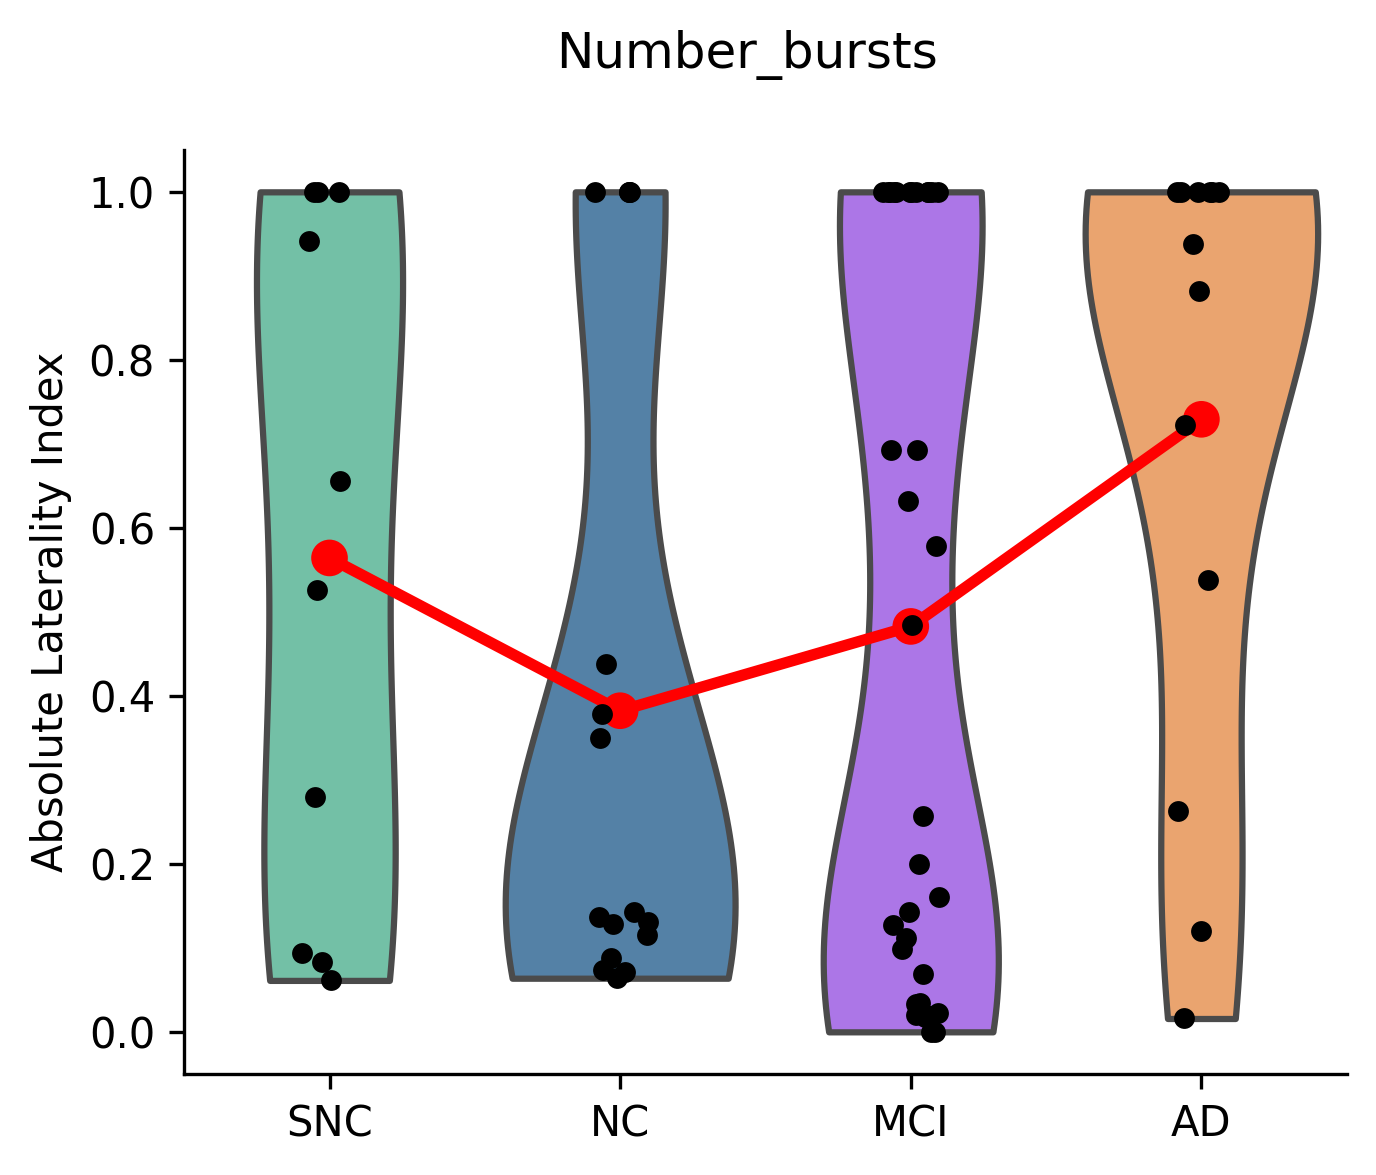

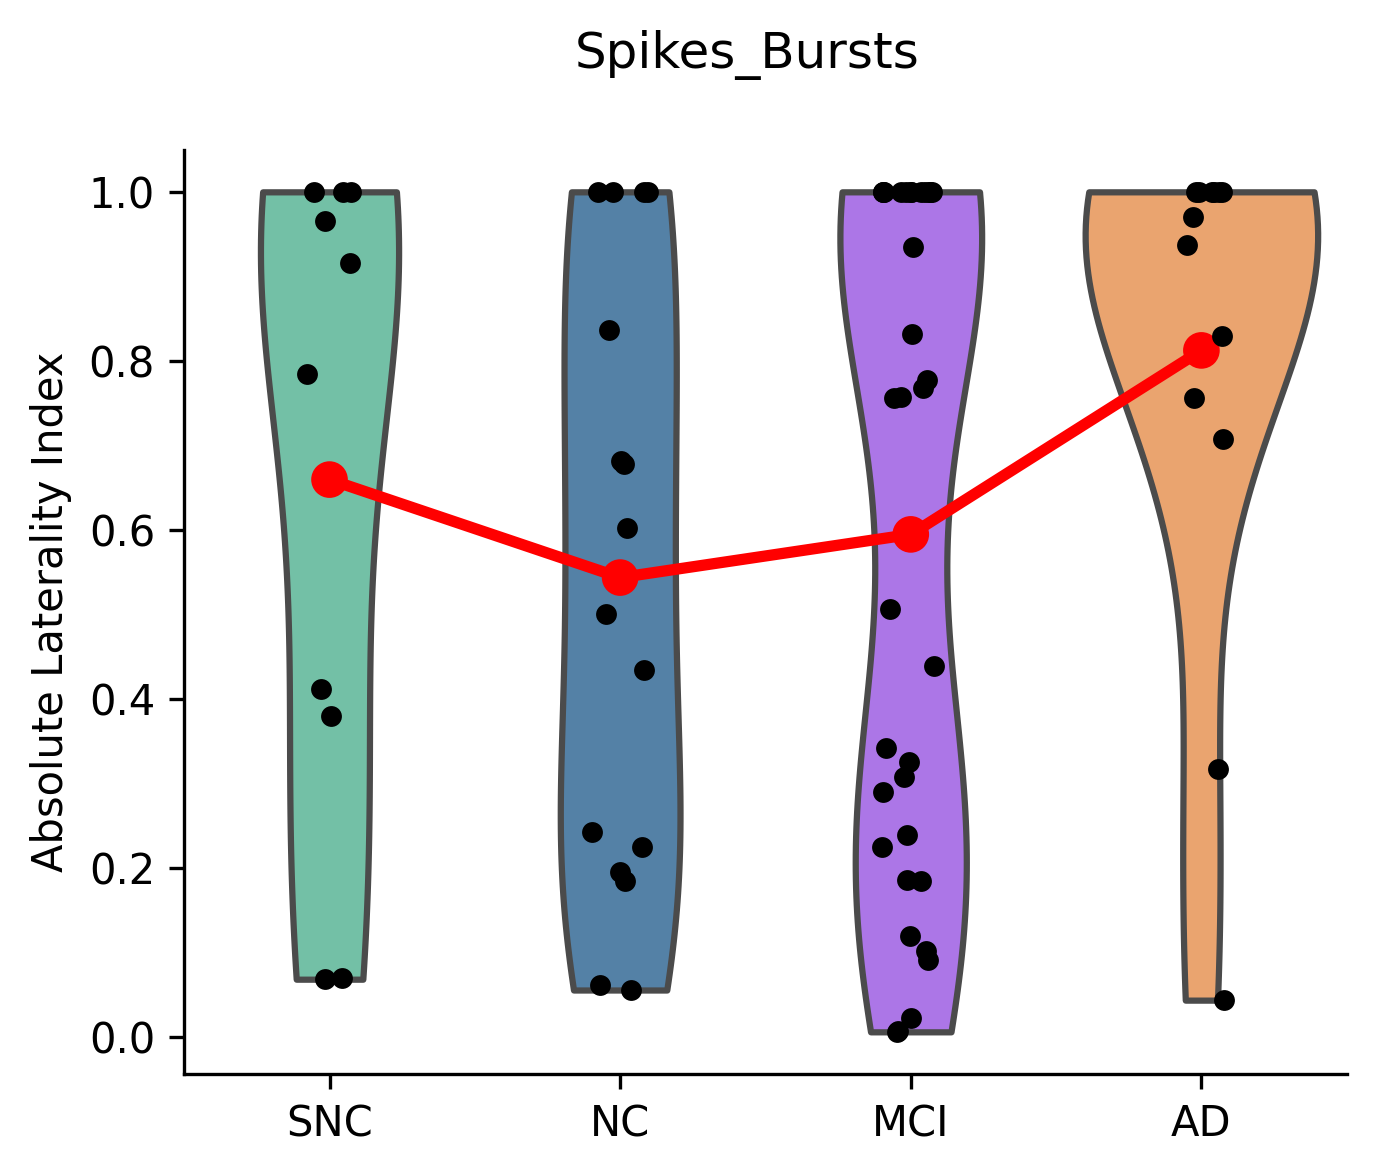

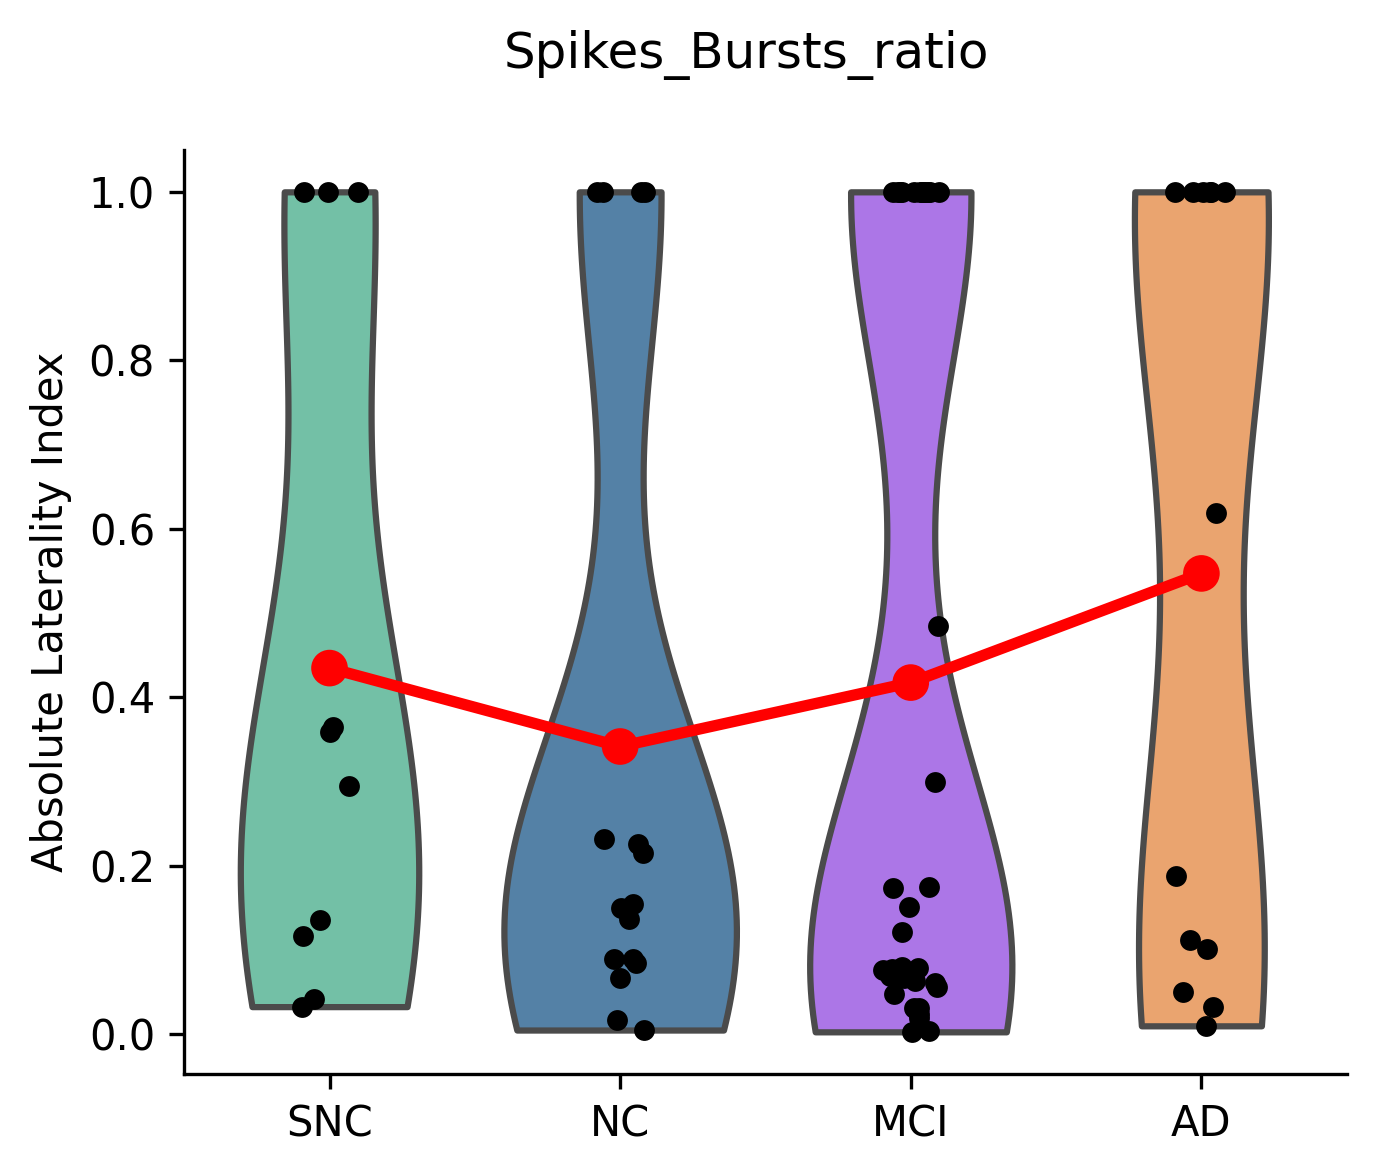

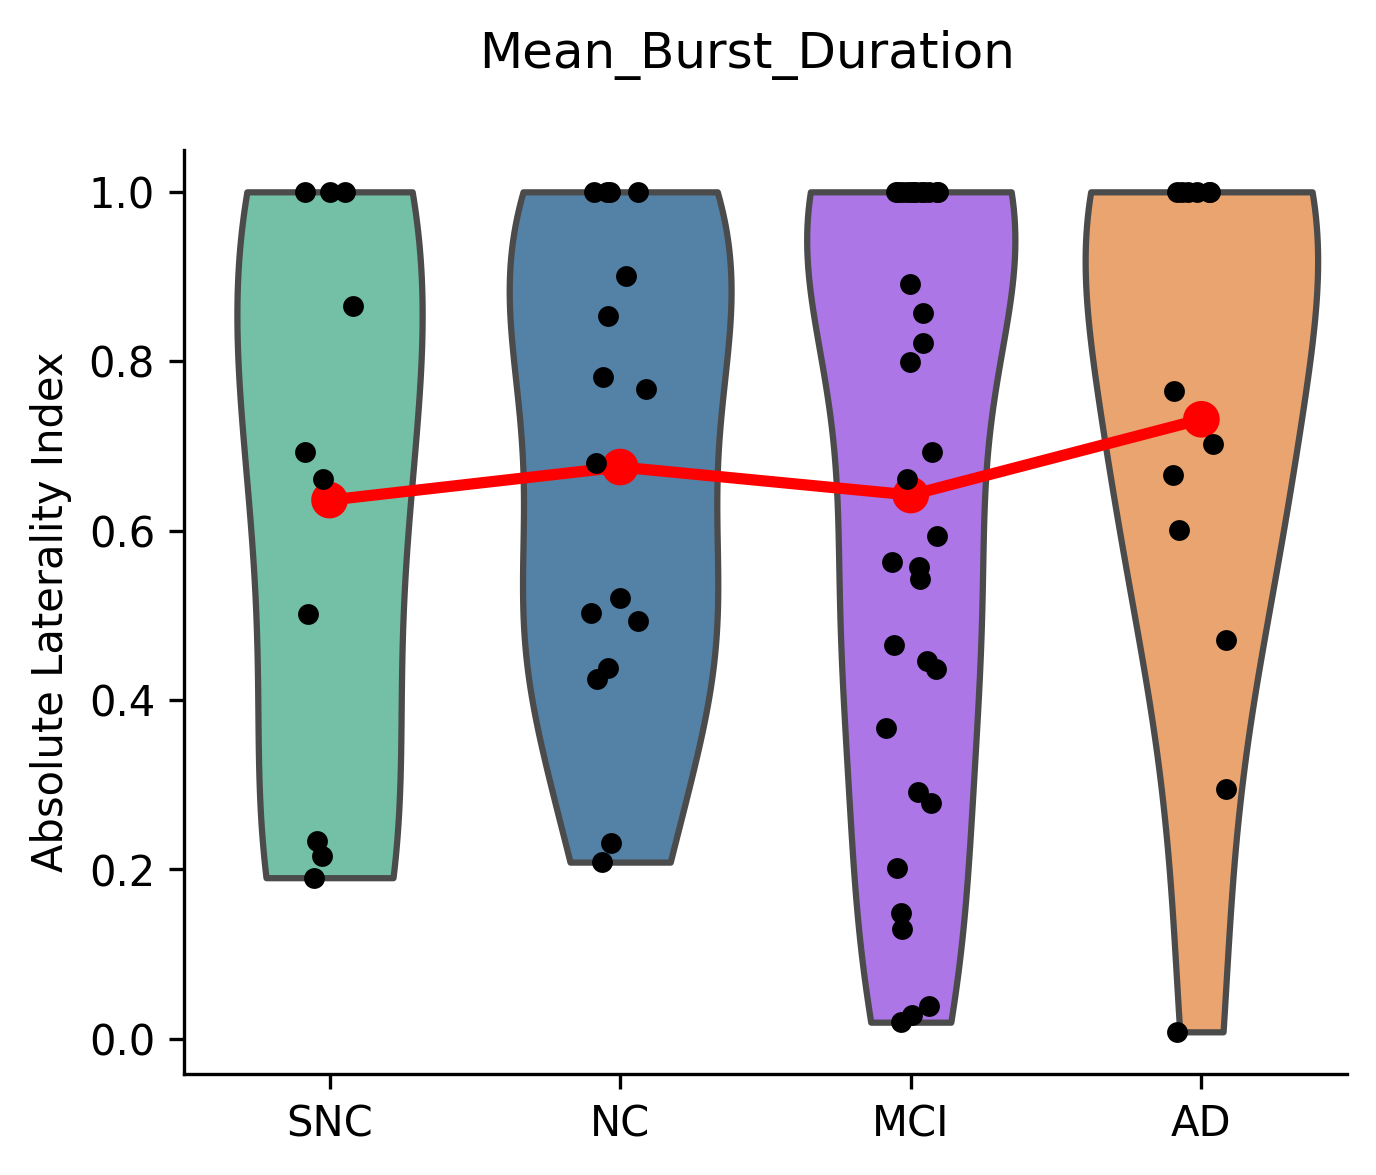

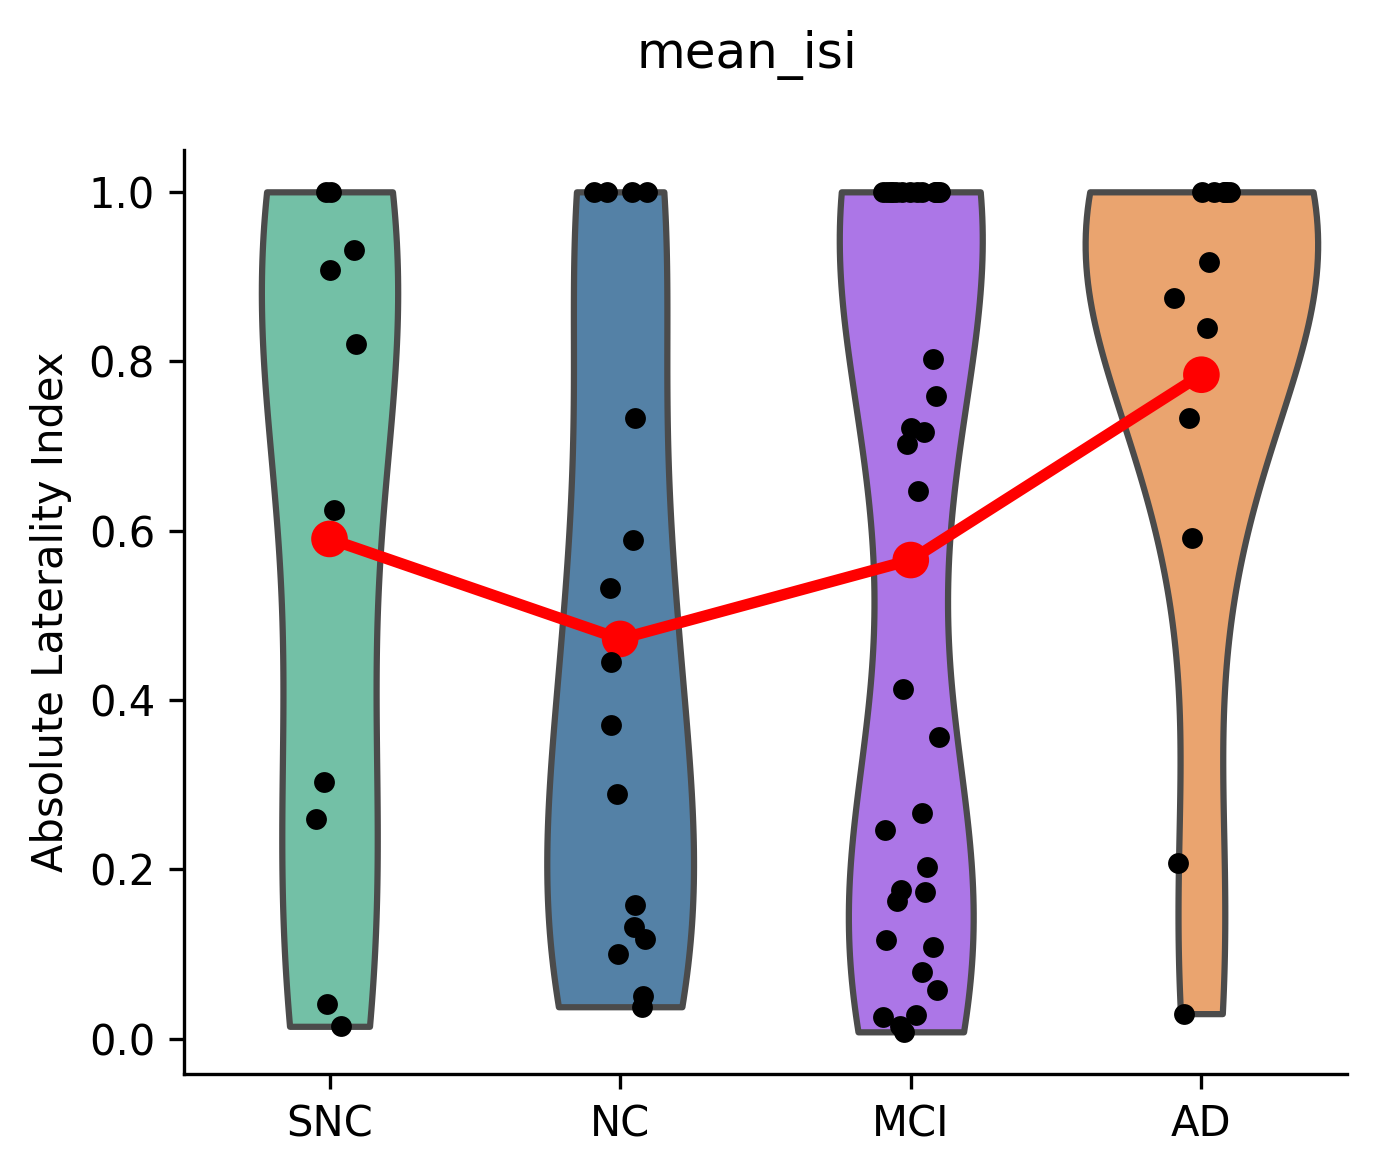

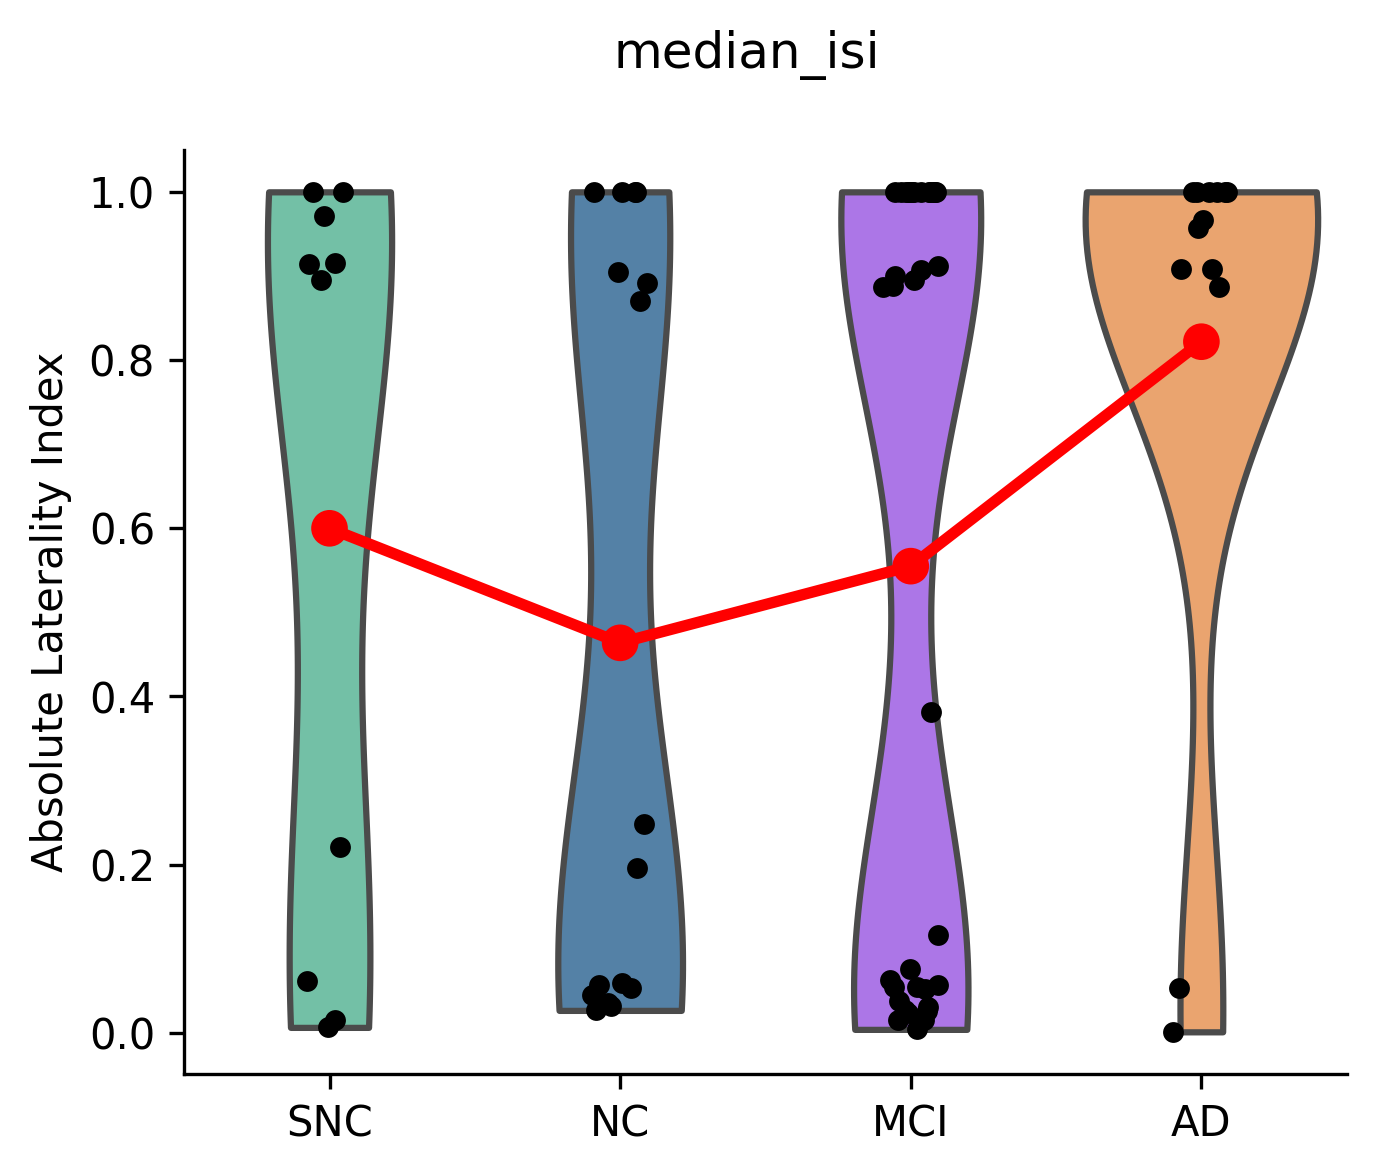

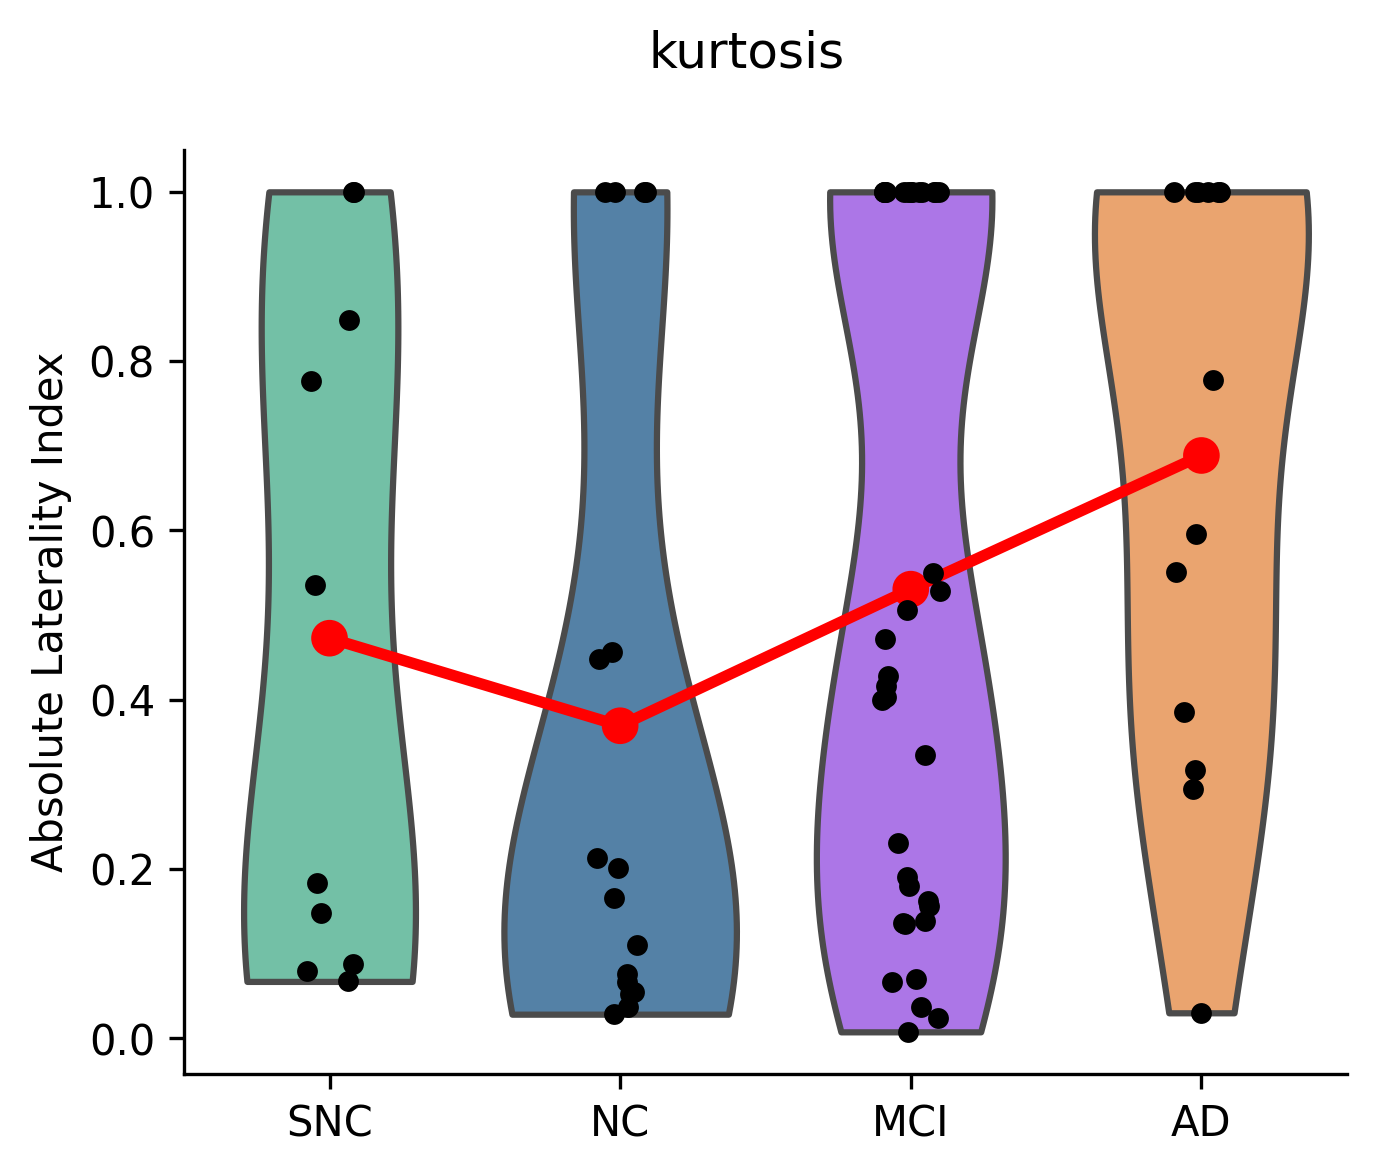

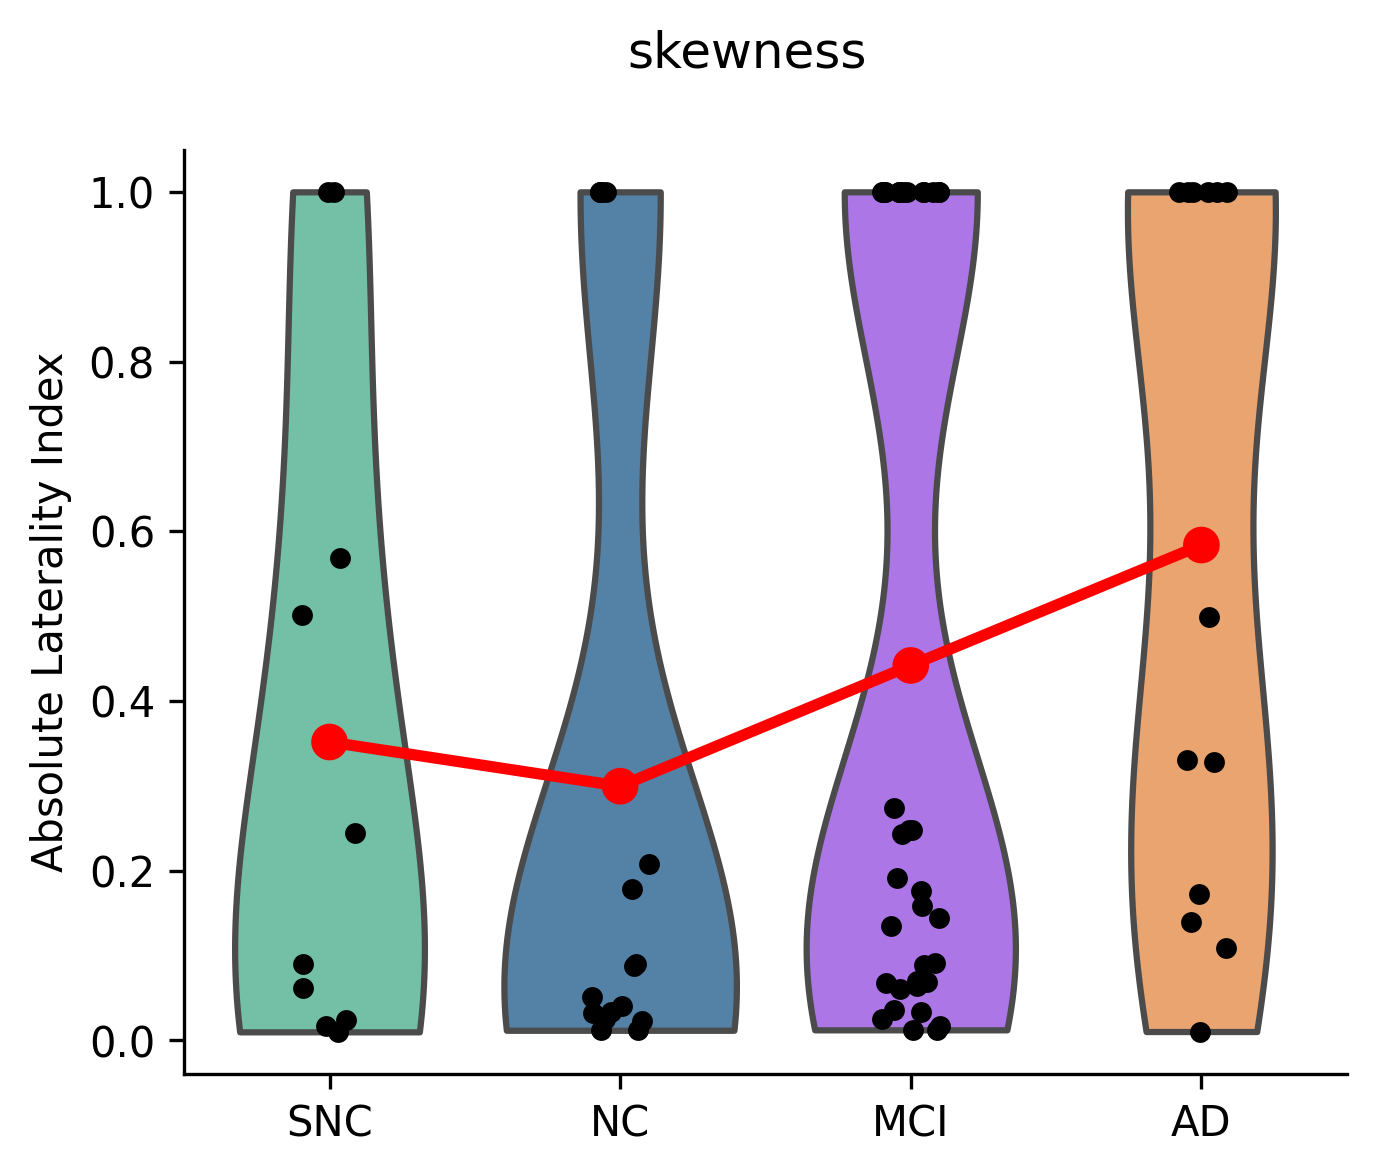

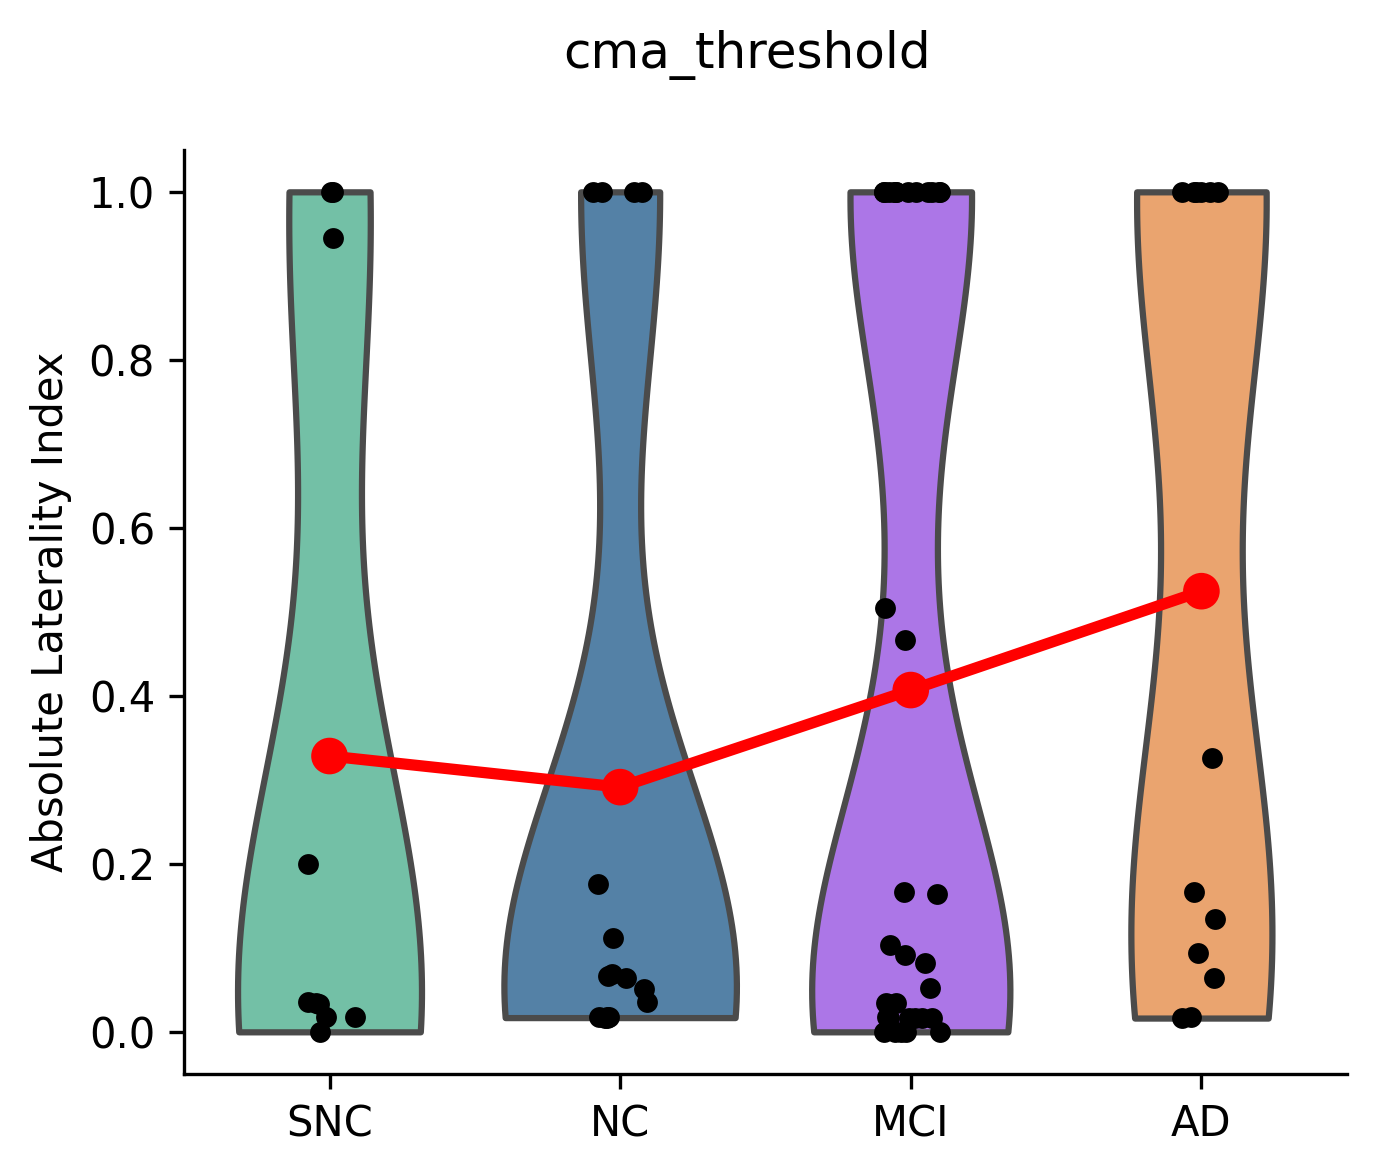

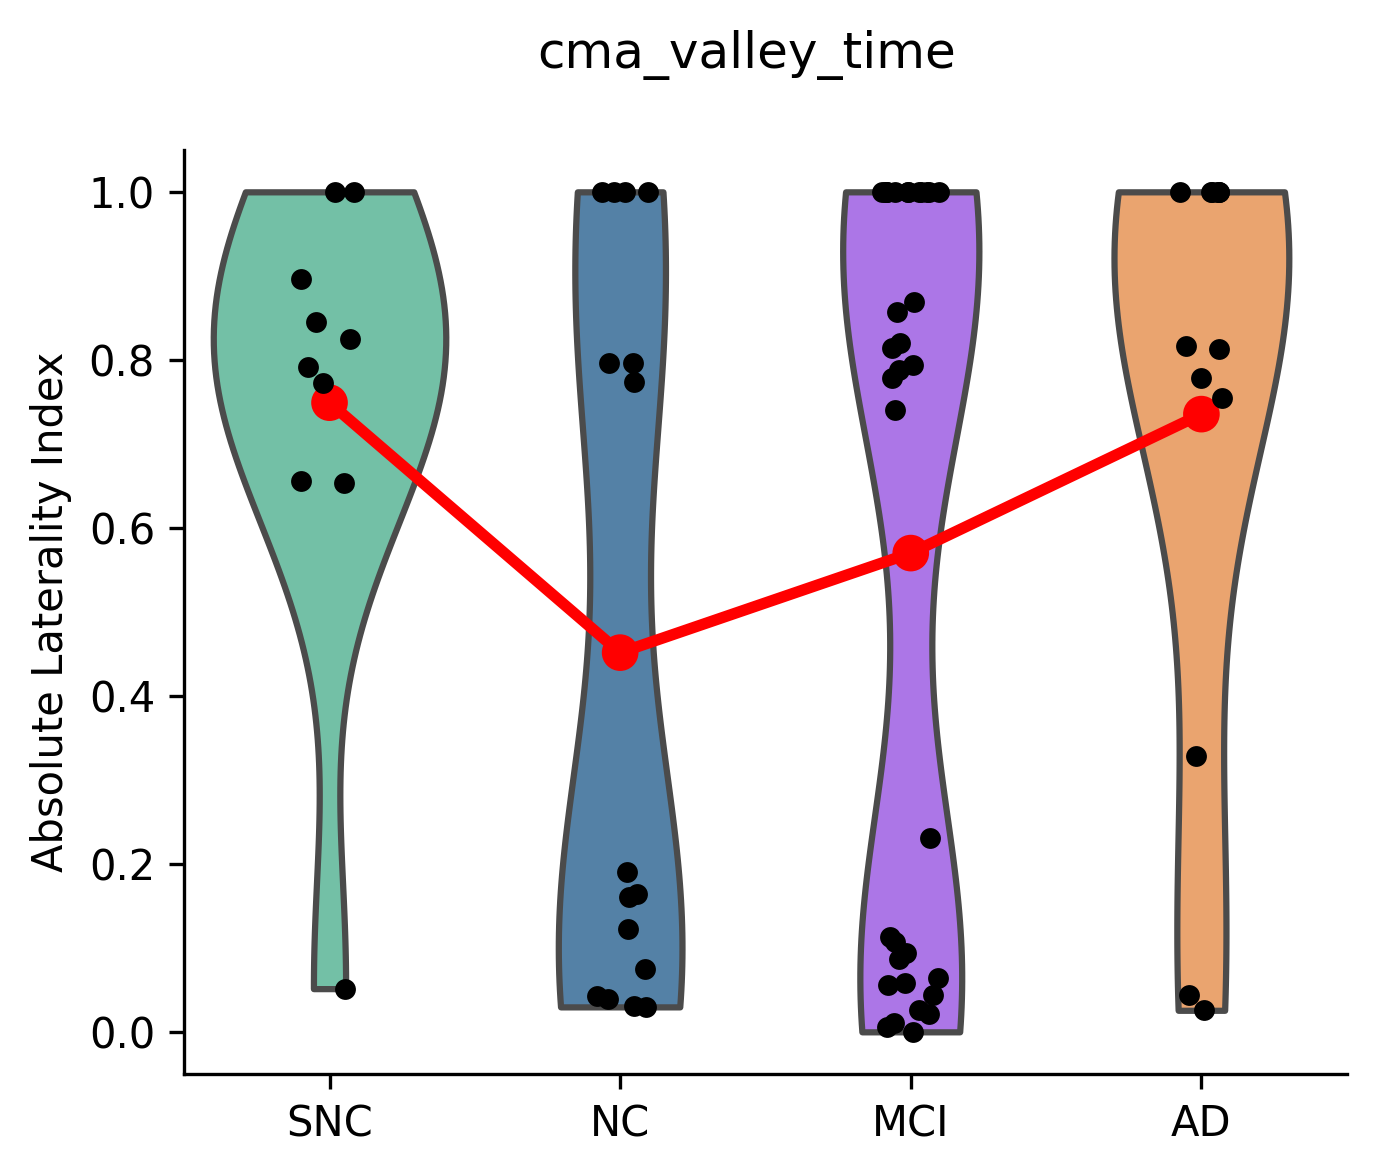

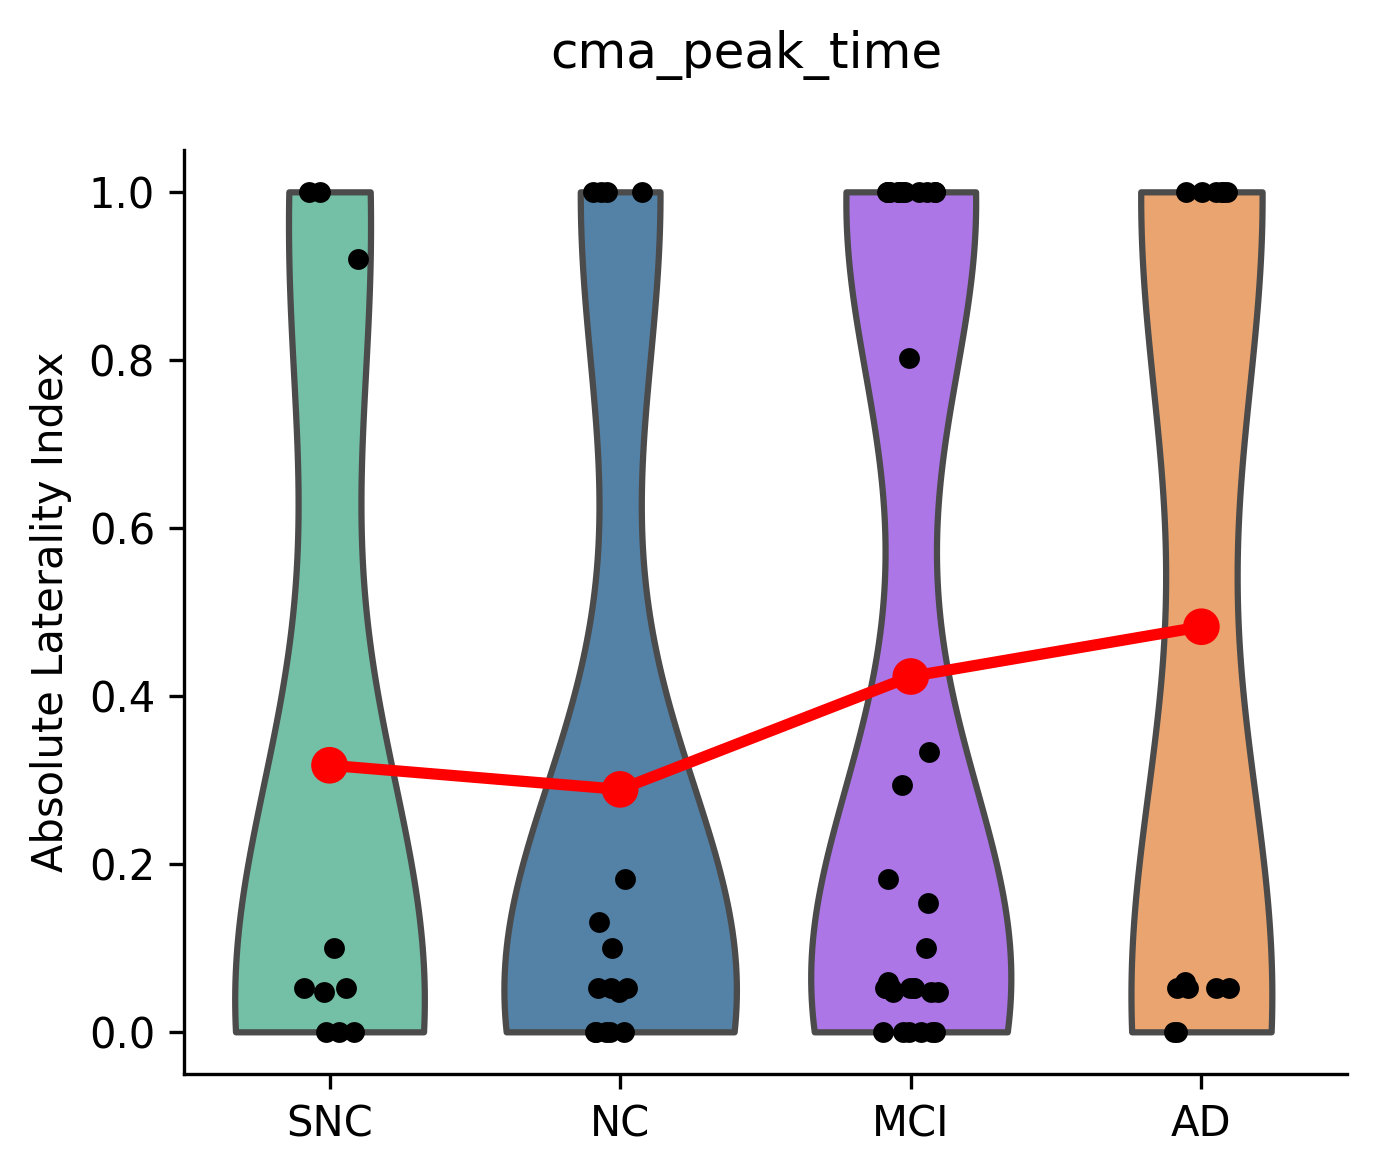

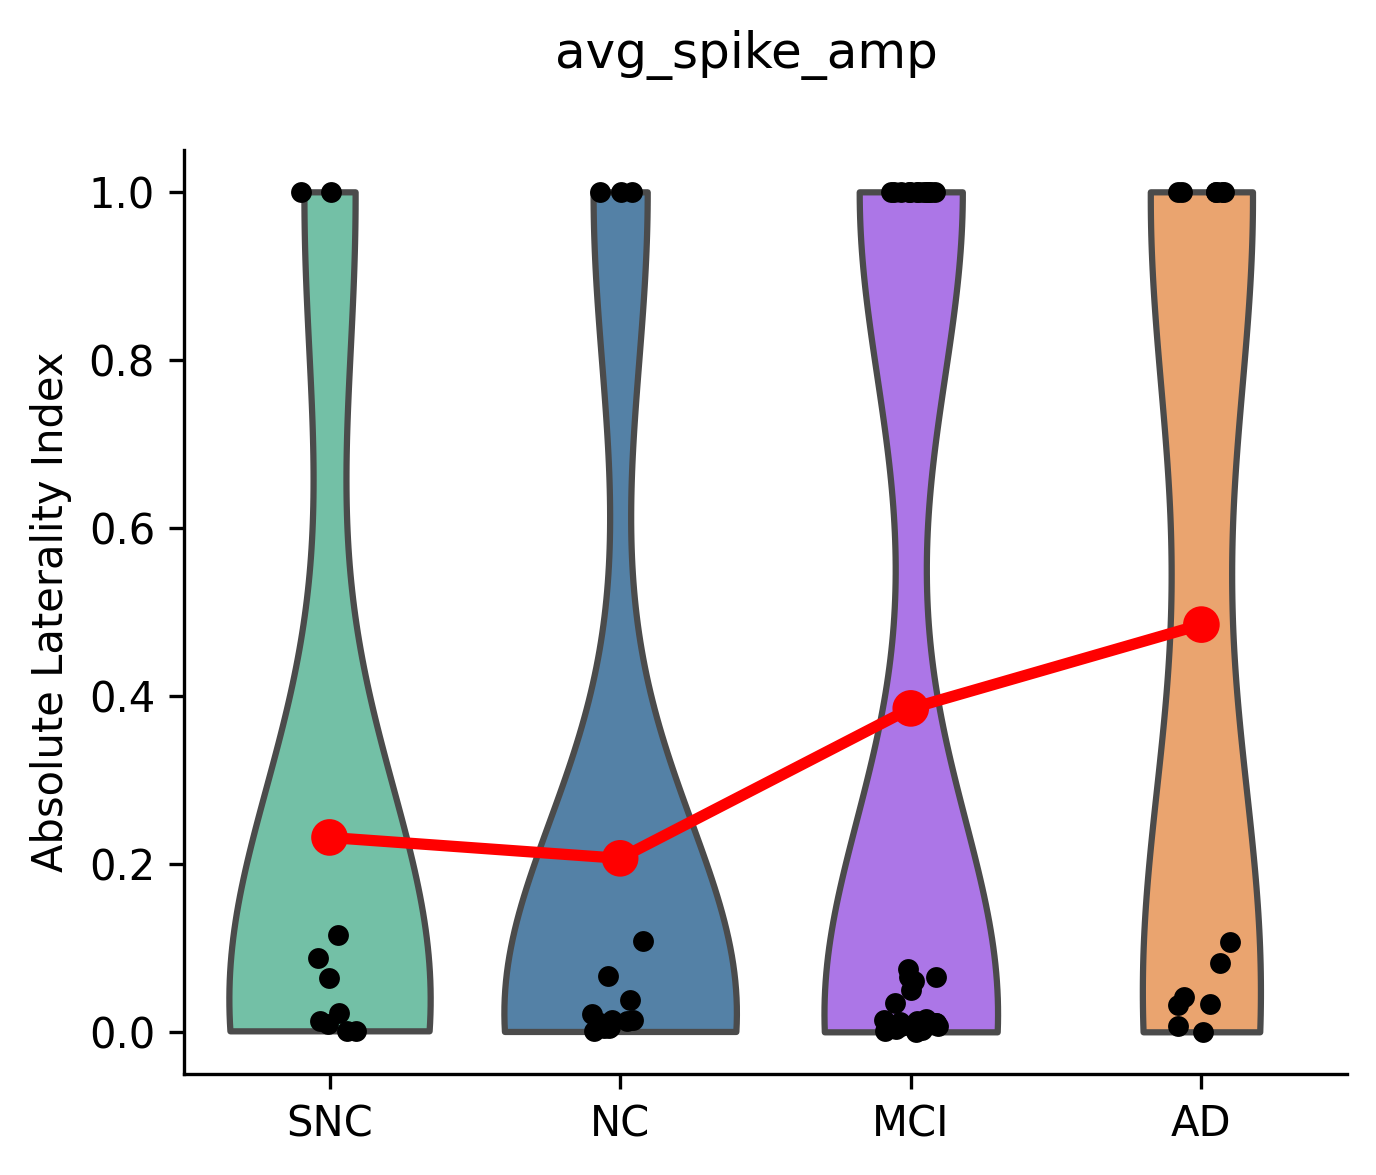

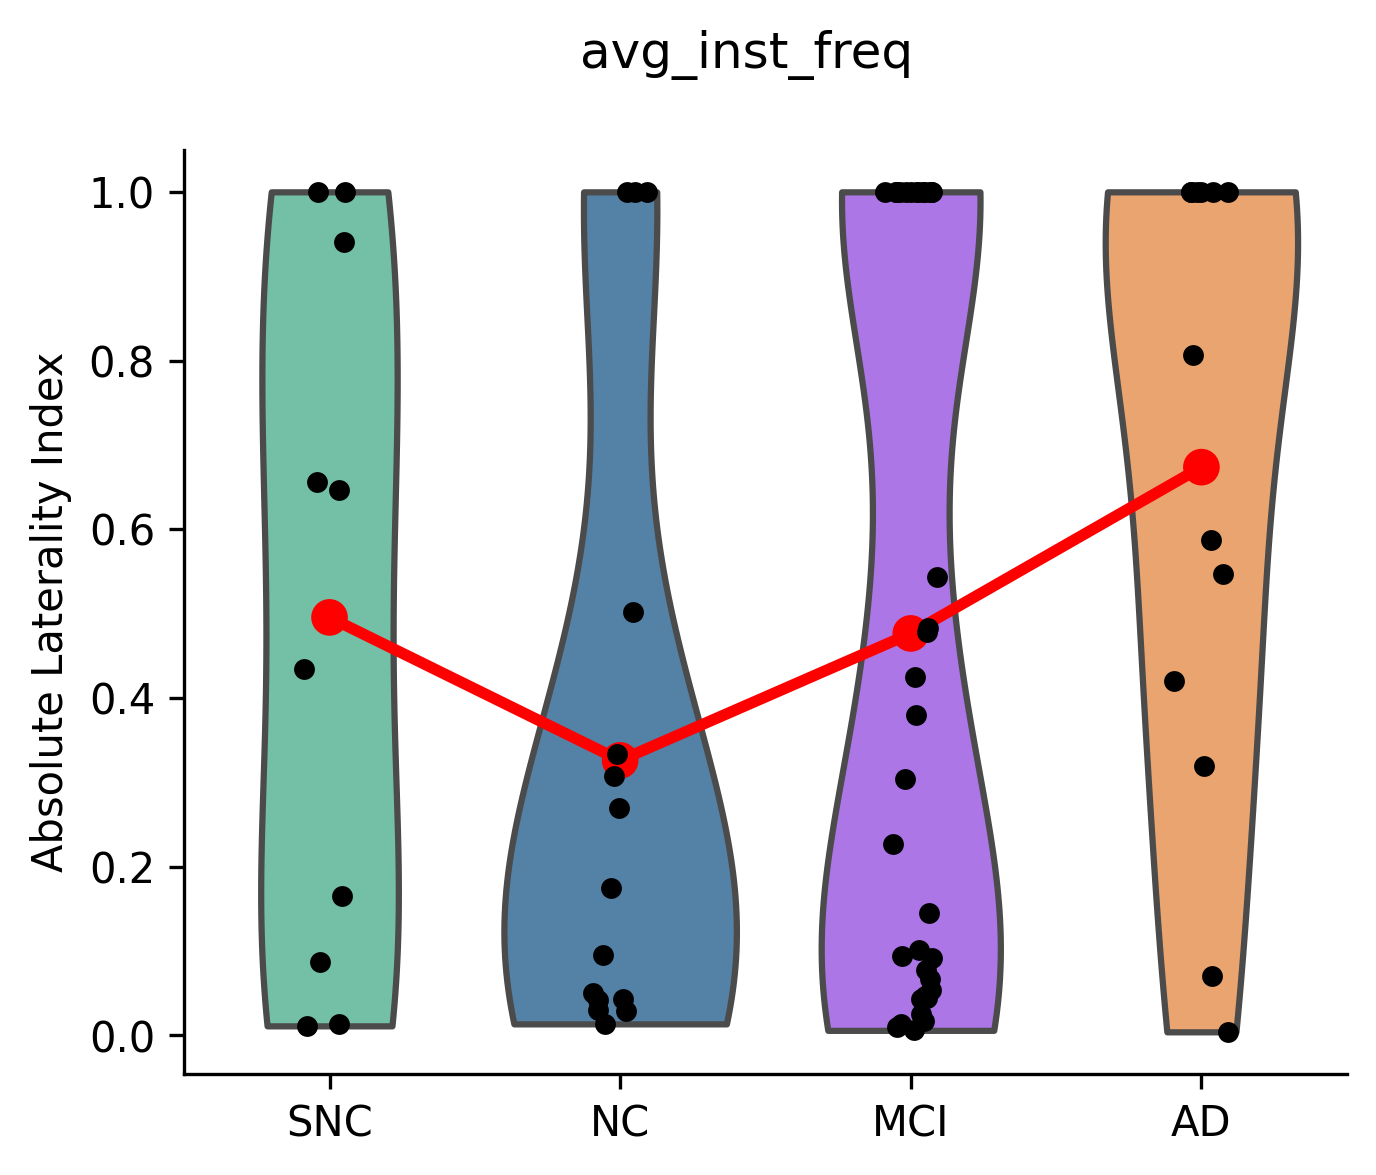

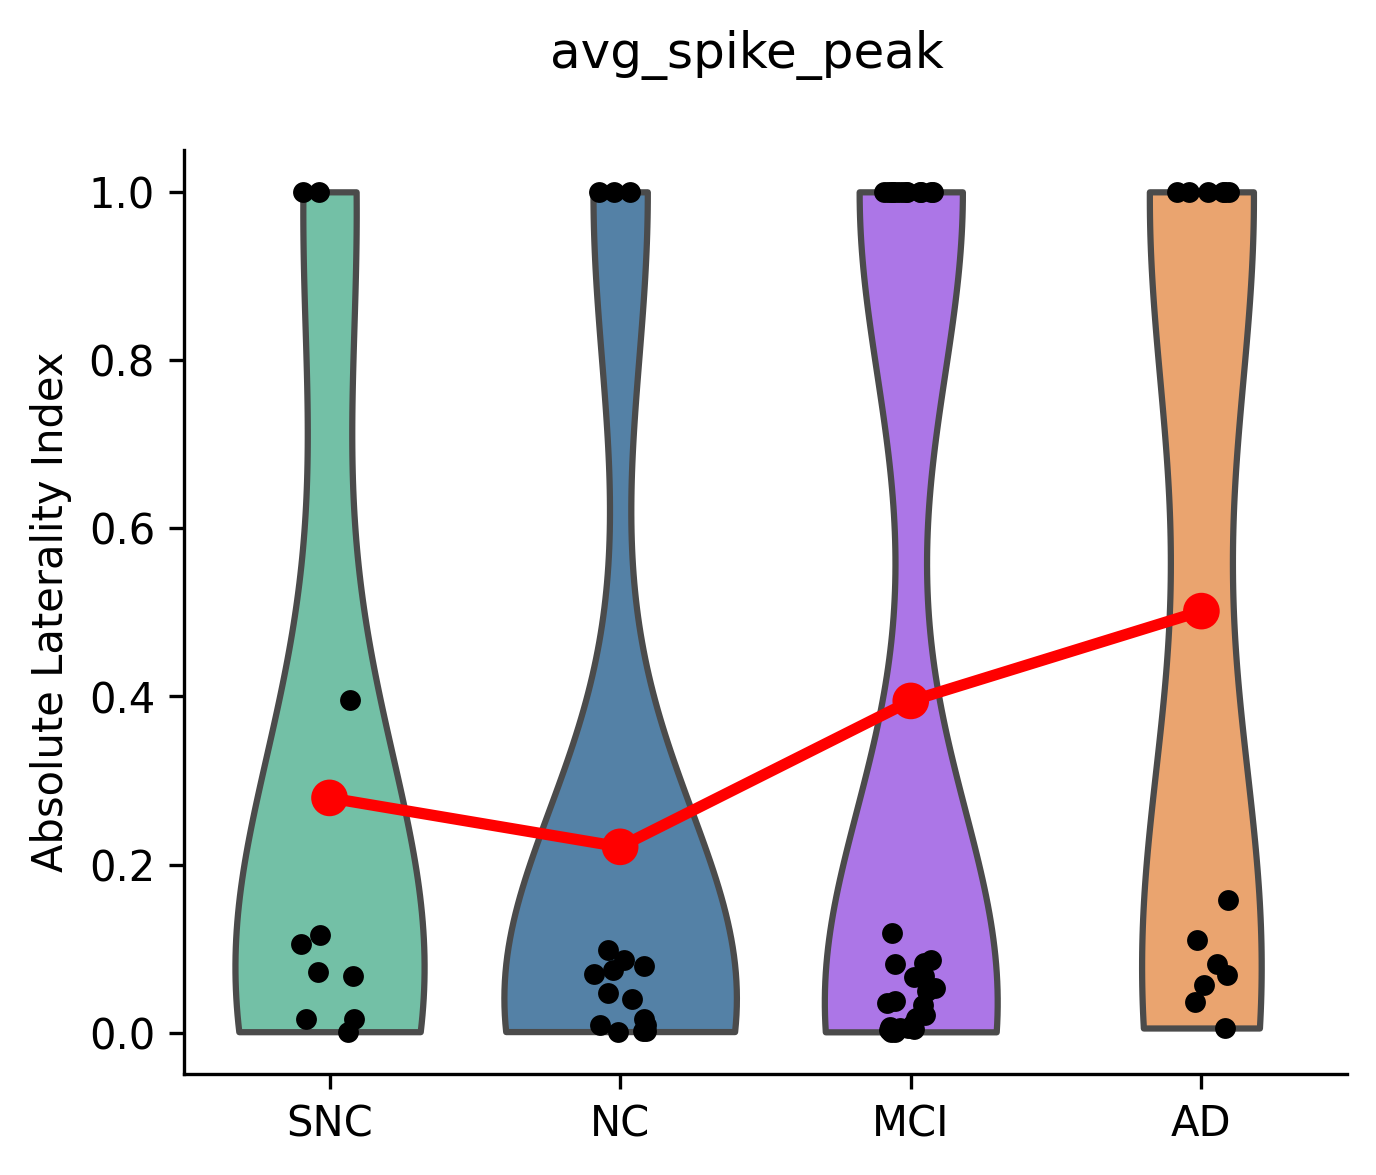

In [16]:
# bursts_results_left = pd.read_csv(pjoin(basedir, "bursts_results_left.csv"))
# bursts_results_right = pd.read_csv(pjoin(basedir, "bursts_results_right.csv"))
# ta = bursts_results_left
# col = ta.columns[3:]
# colors = ['#7F58AF','#64C5EB','#E84D8A','#FEB326']
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
for var in col:
    figure = plt.figure(figsize=(5, 4), dpi=300)
    print(var)
    sns.violinplot(x=bursts_results_left.group, y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]), cut=0, inner = None, palette=colors)
    sns.stripplot(x=bursts_results_left.group, y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]), dodge=True, jitter=True, color='black')
    sns.pointplot(x=bursts_results_left.group, y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]), color='r', errorbar=None)
    plt.ylabel("Absolute Laterality Index")
    # hide "group" label
    plt.xlabel("")
    # statannot.add_stat_annotation(
    #     ax=figure.gca(),
    #     x=bursts_results_left.group,
    #     y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]),
    #     box_pairs=[
    #         (("SNC"), ("NC")), (("NC", "AD"))],
    #     test='Mann-Whitney',
    #     text_format="star")

    # hide top and right frame
    sns.despine(top=True, right=True)
    plt.suptitle(var)
    # automatically add spaces beyond y axis

In [17]:
small_burst = pd.DataFrame()
small_burst['group'] = bursts_results_left.group
small_burst['caseid'] = bursts_results_left.caseid
for i in col_names[3:]:
    small_burst[i] = abs(bursts_results_right[i] - bursts_results_left[i])/ (bursts_results_left[i] + bursts_results_right[i])
print(small_burst)

   group caseid  Number_bursts  Spikes_Bursts  Spikes_Bursts_ratio  \
0    SNC  2820A       0.526316       0.783784             0.294876   
1    SNC  3168A       0.655172       0.916318             0.365246   
2    SNC  3358A       1.000000       1.000000             1.000000   
3    SNC  3610A       1.000000       1.000000             1.000000   
4    SNC  4073A       0.941176       0.965517             0.359165   
..   ...    ...            ...            ...                  ...   
69    AD  3255A       0.538462       0.756098             0.032733   
70    AD  4612A       1.000000       1.000000             1.000000   
71    AD  5368A       0.937500       0.970149             0.618391   
72    AD  5571A       1.000000       1.000000             1.000000   
73    AD  7673A       0.263158       0.707113             0.187468   

    Mean_Burst_Duration  mean_isi  median_isi  kurtosis  skewness  \
0              0.660653  0.624810    0.895057  0.079306  0.016480   
1              0.8657

In [18]:
import sys
from tvbtools.tools.statools import permutation_test, stats_calculator
stats_calculator(small_burst, tails="less")

(SNC, NC)     (SNC, MCI)  (SNC, AD)      (NC, MCI)  \
Number_bursts             0.874013  0.00019998***   0.186461  0.00019998***   
Spikes_Bursts             0.777722  0.00019998***   0.180582  0.00019998***   
Spikes_Bursts_ratio       0.705729  0.00019998***   0.325767  0.00019998***   
Mean_Burst_Duration       0.369663  0.00019998***   0.364164  0.00019998***   
mean_isi                  0.778822       0.677572   0.211979       0.332367   
median_isi                0.755324       0.683932   0.280772       0.351415   
kurtosis                  0.736726       0.406279   0.159884       0.159884   
skewness                  0.622838       0.313289   0.230527       0.230527   
cma_threshold             0.558744  0.00019998***   0.170023  0.00019998***   
cma_valley_time           0.966903  0.00019998***   0.644816  0.00019998***   
cma_peak_time             0.557744  0.00019998***   0.343406  0.00019998***   
avg_spike_amp             0.658134       0.277622   0.251775       0.251775   
avg_inst_freq        0.00019998***       0.540746   0.171703  0.00019998***   
avg_spike_peak            0.660734       0.319768   0.281772       0.281772   

                                  (NC, AD)      (MCI, AD)  
Number_bursts                 0.017548245*  0.00019998***  
Spikes_Bursts        0.030296970000000003*  0.00019998***  
Spikes_Bursts_ratio               0.168433  0.00019998***  
Mean_Burst_Duration               0.364164  0.00019998***  
mean_isi                          0.083992       0.144886  
median_isi                        0.112189       0.112189  
kurtosis                           0.10319       0.159884  
skewness                          0.230527       0.230527  
cma_threshold                     0.093441  0.00019998***  
cma_valley_time                   0.054445  0.00019998***  
cma_peak_time                     0.223778  0.00019998***  
avg_spike_amp                     0.251775        0.39812  
avg_inst_freq                0.00019998***       0.116988  
avg_spike_peak                    0.189581       0.356844

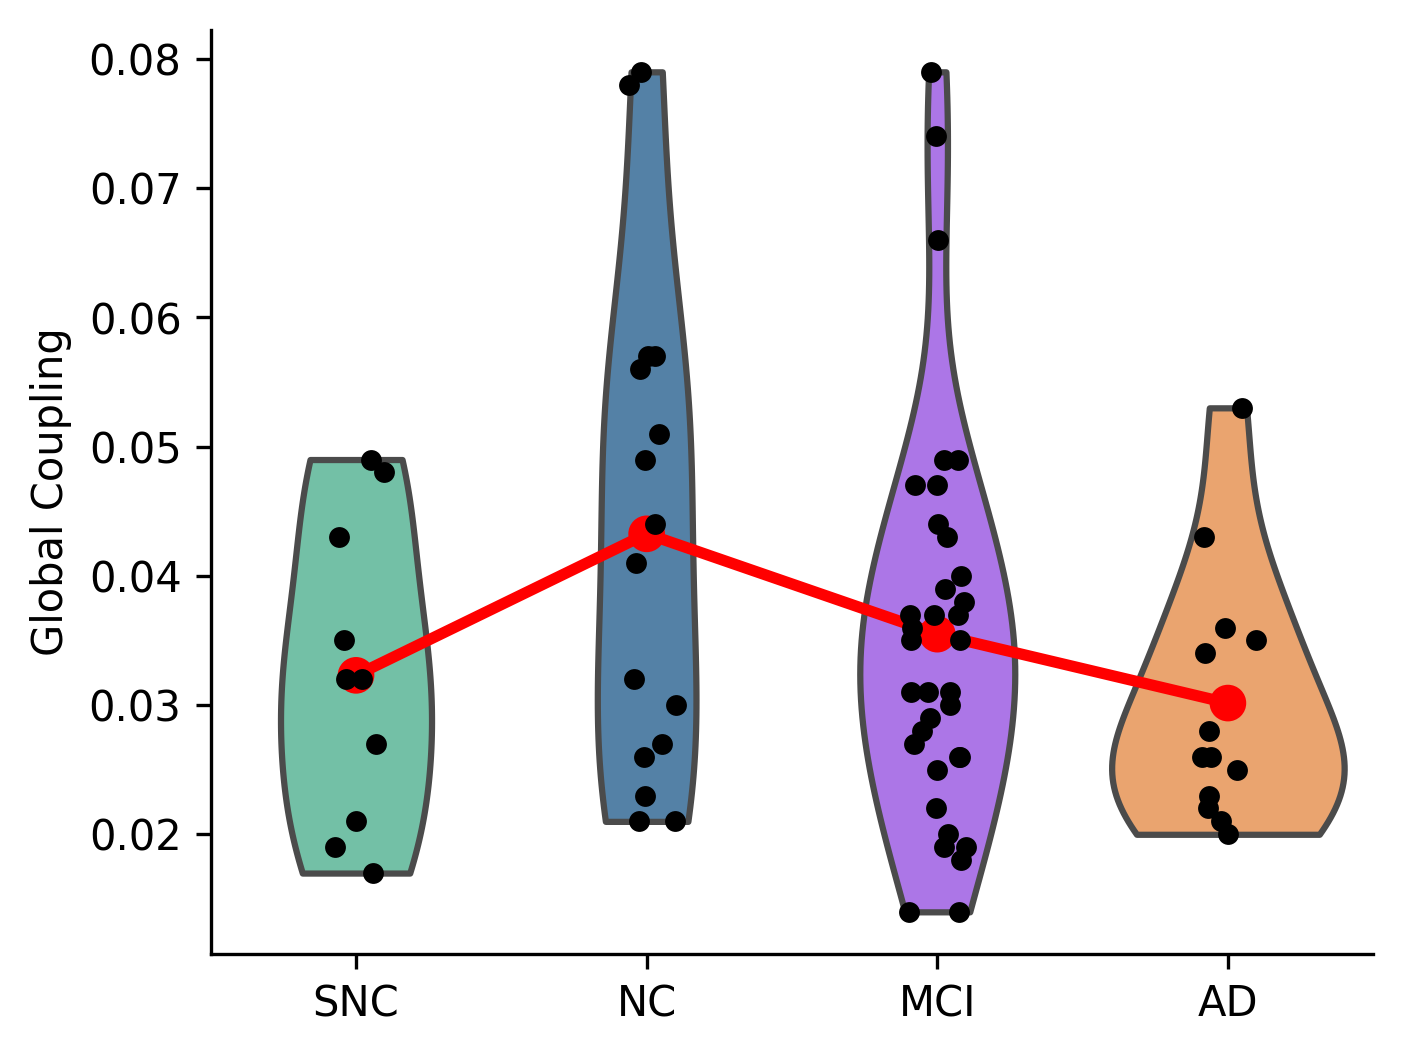

In [19]:
# colors = ['#7F58AF','#64C5EB','#E84D8A','#FEB326']
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
mega = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
figure = plt.figure(figsize=(5, 4), dpi=300)
sns.violinplot(x="group", y="Gmax", data=mega, cut=0, inner = None, palette=colors)
sns.stripplot(x="group", y="Gmax", data = mega,dodge=True, jitter=True, color='black')
sns.pointplot(x="group", y="Gmax", data=mega, color='r', errorbar=None)
plt.ylabel("Global Coupling")
# hide "group" label
plt.xlabel("")
# statannot.add_stat_annotation(
#     ax=figure.gca(),
#     x=bursts_results_left.group,
#     y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]),
#     box_pairs=[
#         (("SNC"), ("NC")), (("NC", "AD"))],
#     test='Mann-Whitney',
#     text_format="star")

# hide top and right frame
sns.despine(top=True, right=True)
# plt.suptitle("Global Coupling (Maximum)")
# automatically add spaces beyond y axis